# Nonisotropic Noise

May 17, 2022

### Part 1: Low-D noise, vary with M

### Part 2: Increase dimension of noise

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator,FixedFormatter
import matplotlib.pylab as pylab

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import interpolate # don't import stats
from scipy import linalg as LA
from scipy.ndimage.filters import uniform_filter1d

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy
import pickle

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("../..")

In [2]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.bptt import BPTT
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE
from algorithms.track_vars import TrackVars

from utils.plotting import plot_trained_trajectories, paper_format
from utils.metric import cos_sim, return_norm_and_angle
from utils.functions import choose_aligned_matrix

from utils.metric import cos_sim, flow_field_data, flow_field_predicted, calculate_flow_field_correlation


In [3]:
folder = 'figs-2022-5-18/'

### QR Decomposition

In [21]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,
               sig_in=0.0,sig_rec=0.25,sig_out=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               rng=np.random.RandomState(72))

net0 = RNN(params)

w_m = choose_aligned_matrix(net0.w_out.T,n_change=50,overlap=0.5,rng=np.random.RandomState(56),zero=False,tolerance=0.01,loop=1000)


Q,R = LA.qr(w_m) # want 2 x 50

M norm: 2.46	 M angle: 0.50, 74 iterations

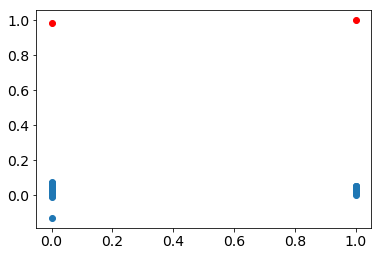

In [40]:
for i in range(50):
    if i ==0:
        color = 'r'
    else:
        color='C0'
    plt.plot(0,np.corrcoef(w_m[:,0],Q[i])[0,1],'o',color=color)
    plt.plot(1,np.corrcoef(Q[:,0],Q[:,i])[0,1],'o',color=color)

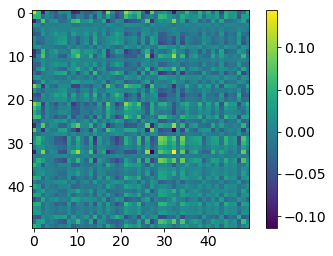

In [37]:
# create a covariance matrix based on QR decomposition of w_m
Q,R = LA.qr(w_m)
u0 = Q[:,0]
u1 = Q[:,1]

Sigma = np.outer(u0,u0) + np.outer(u1,u1)

plt.imshow(Sigma)
plt.colorbar()

In [3]:
trial_duration = 20
n_in=4
frac_on = 0.2

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

# Train RFLO with low-D covariance, vary alignment of M with Sigma

The recipe here is as follows:

4it [00:00, 38.32it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.25
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.2
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7ff7d67373a8>


2500it [00:28, 87.04it/s]


M norm: 1.00	 M angle: 0.61, 22 iterations
w_out1 norm: 1.50	 w_out vs. w_out1 angle: 0.50
w_m norm: 1.00	 w_out1 vs. w_m angle: 0.61
M norm: 1.07	 M angle: 0.40, 12 iterations
 w_m vs. w_m_sigma angle: 0.40
 w_out1 vs. w_m_sigma angle: 0.23

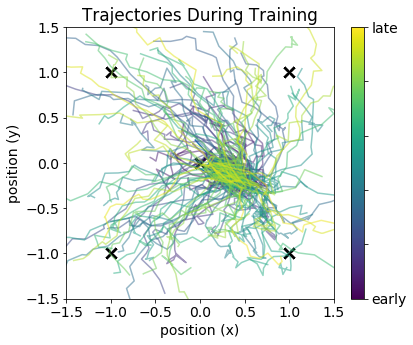

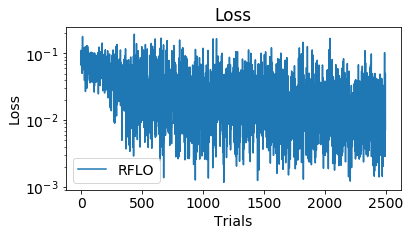

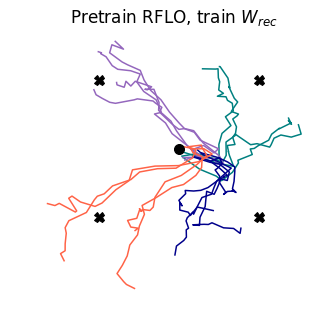

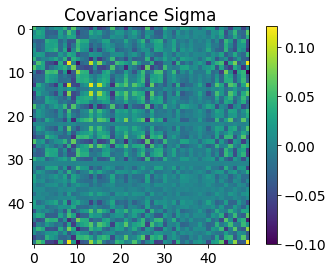

500it [00:05, 97.59it/s] 
1000it [00:13, 76.23it/s]
500it [00:05, 92.27it/s]


AR early fit 0.888, late fit 0.917


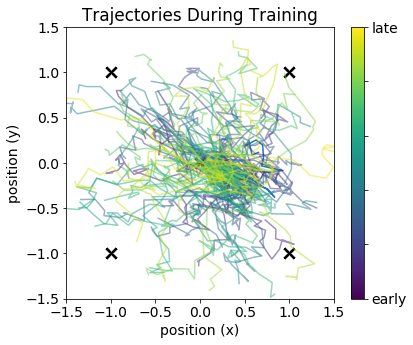

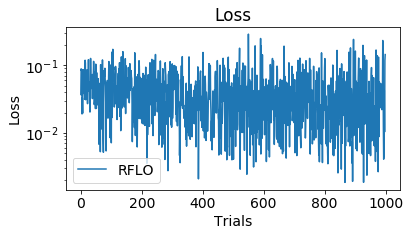

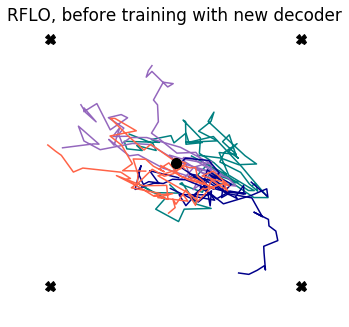

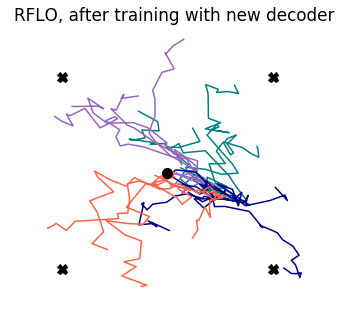

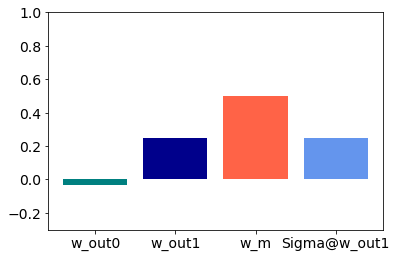

M norm: 1.00	 M angle: 0.61, 22 iterations
w_out1 norm: 1.50	 w_out vs. w_out1 angle: 0.50
w_m norm: 1.00	 w_out1 vs. w_m angle: 0.61
M norm: 0.99	 M angle: 0.49, 6 iterations
 w_m vs. w_m_sigma angle: 0.49
 w_out1 vs. w_m_sigma angle: 0.30

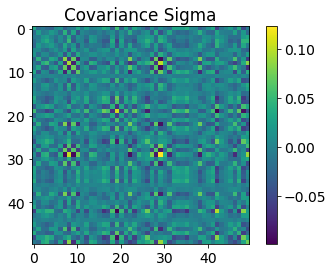

500it [00:04, 103.70it/s]
1000it [00:12, 59.23it/s]
500it [00:04, 104.42it/s]


AR early fit 0.888, late fit 0.917


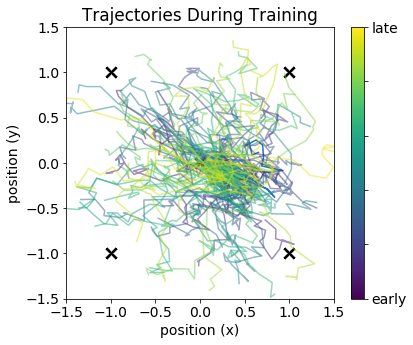

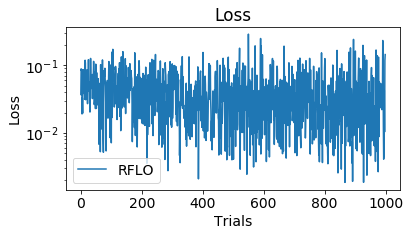

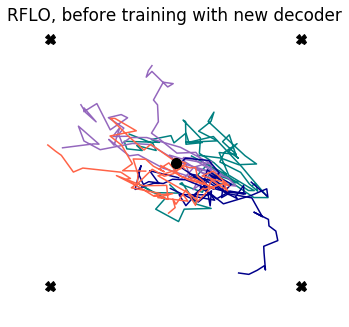

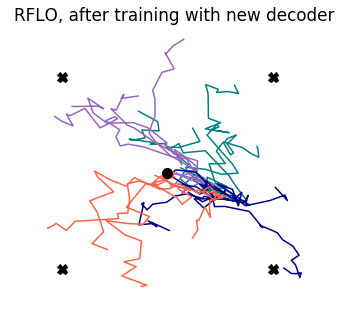

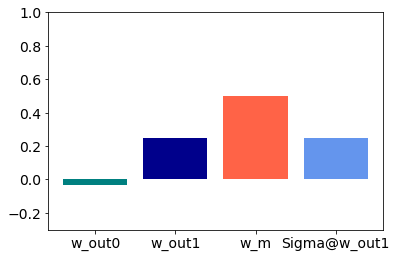

M norm: 1.00	 M angle: 0.61, 22 iterations
w_out1 norm: 1.50	 w_out vs. w_out1 angle: 0.50
w_m norm: 1.00	 w_out1 vs. w_m angle: 0.61
M norm: 0.65	 M angle: 0.80, 22 iterations
 w_m vs. w_m_sigma angle: 0.80
 w_out1 vs. w_m_sigma angle: 0.49

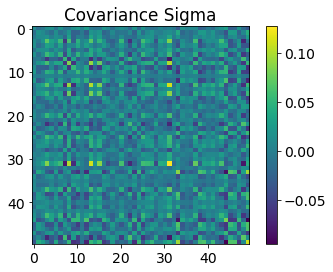

500it [00:06, 83.18it/s] 
1000it [00:10, 93.98it/s]
500it [00:04, 107.99it/s]


AR early fit 0.888, late fit 0.917


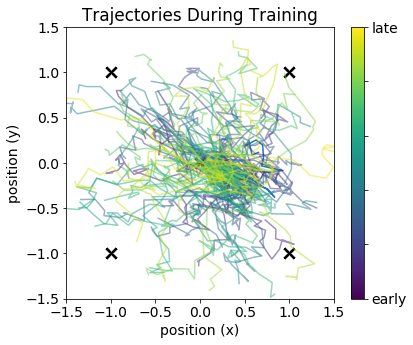

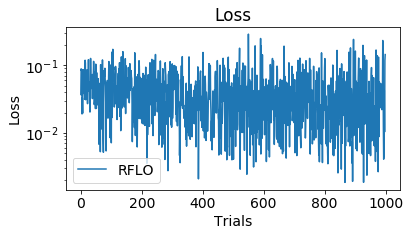

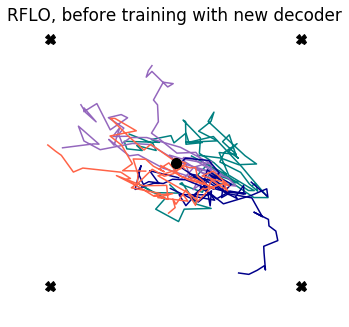

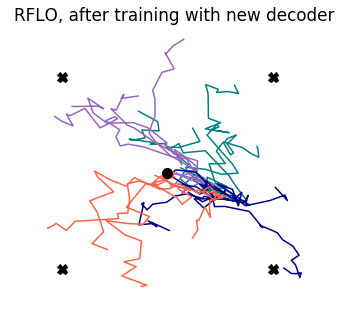

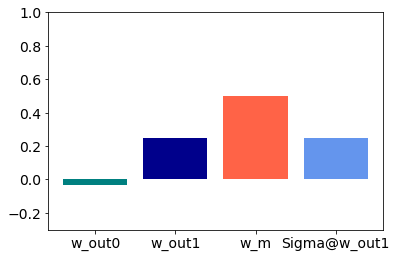

M norm: 1.08	 M angle: 0.59, 7 iterations
w_out1 norm: 1.50	 w_out vs. w_out1 angle: 0.51
w_m norm: 1.08	 w_out1 vs. w_m angle: 0.59
M norm: 1.13	 M angle: 0.39, 5 iterations
 w_m vs. w_m_sigma angle: 0.39
 w_out1 vs. w_m_sigma angle: 0.35

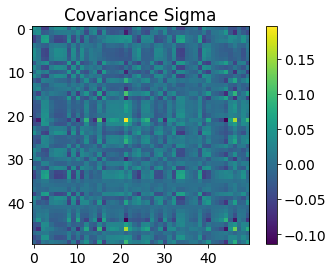

500it [00:04, 108.54it/s]
1000it [00:11, 85.57it/s]
500it [00:05, 87.05it/s] 


AR early fit 0.888, late fit 0.900


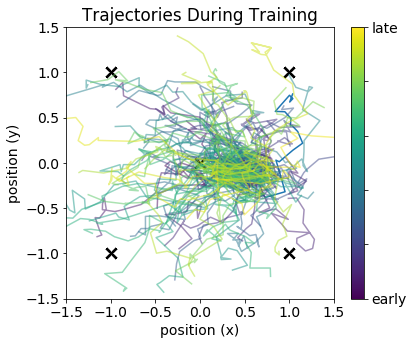

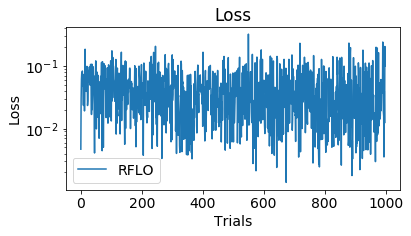

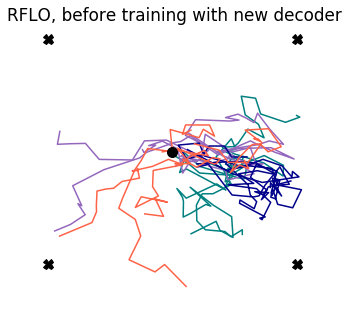

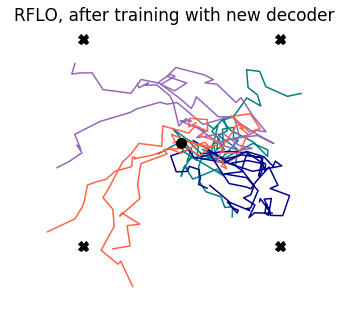

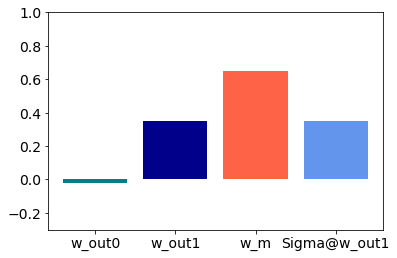

M norm: 1.08	 M angle: 0.59, 7 iterations
w_out1 norm: 1.50	 w_out vs. w_out1 angle: 0.51
w_m norm: 1.08	 w_out1 vs. w_m angle: 0.59
M norm: 1.09	 M angle: 0.49, 2 iterations
 w_m vs. w_m_sigma angle: 0.49
 w_out1 vs. w_m_sigma angle: 0.23

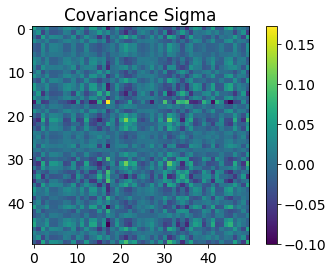

500it [00:04, 117.09it/s]
1000it [00:10, 93.52it/s]
500it [00:04, 104.89it/s]


AR early fit 0.888, late fit 0.900


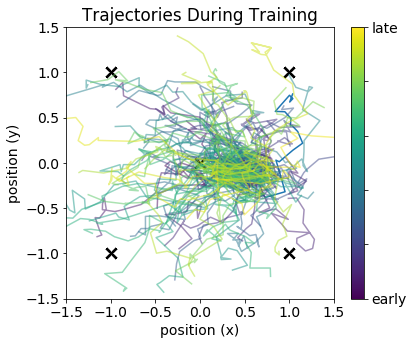

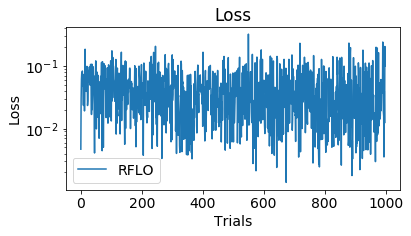

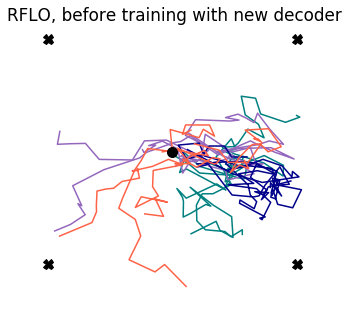

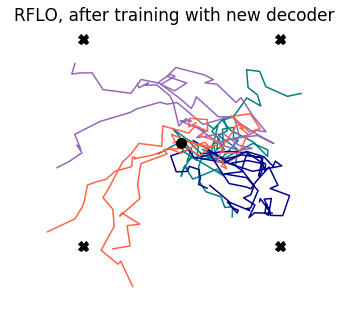

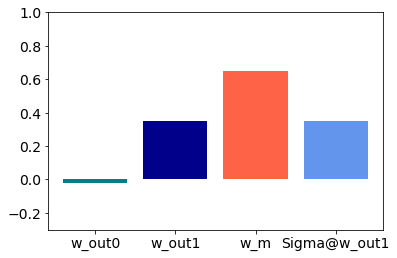

M norm: 1.08	 M angle: 0.59, 7 iterations
w_out1 norm: 1.50	 w_out vs. w_out1 angle: 0.51
w_m norm: 1.08	 w_out1 vs. w_m angle: 0.59
M norm: 0.70	 M angle: 0.80, 1 iterations
 w_m vs. w_m_sigma angle: 0.80
 w_out1 vs. w_m_sigma angle: 0.56

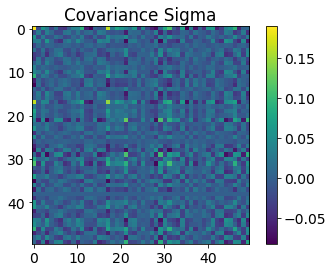

500it [00:04, 117.60it/s]
1000it [00:12, 82.42it/s]
500it [00:04, 105.78it/s]


AR early fit 0.888, late fit 0.900


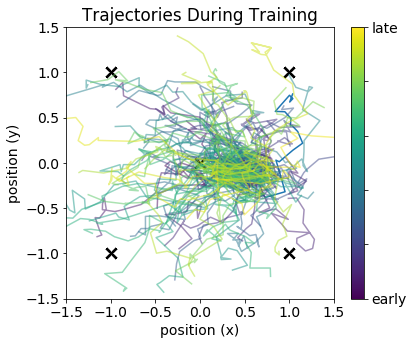

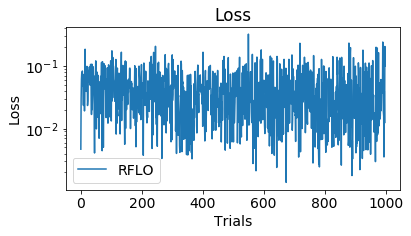

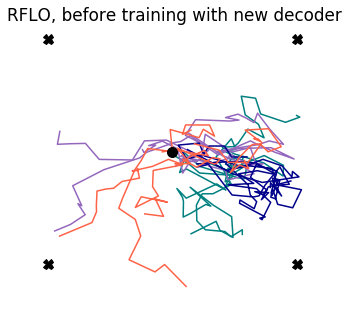

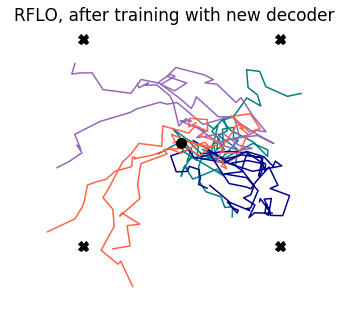

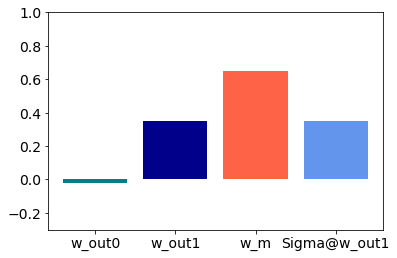

In [6]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.2,eta_out=0.1,
               sig_in=0.0,sig_rec=0.25,sig_out=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               rng=np.random.RandomState(72))
params.print_params()

# Initialize RNN
net0 = RNN(params)
sim0 = Simulation(net0)
rflo = RFLO(net0,apply_to=['w_rec'],online=False)
sim0.run_session(n_trials=2500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=20)

fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='Pretrain RFLO, train '+r'$W_{rec}$')






""" Average over multiple seeds """
# seeds = [0,22,33,47] #,54,72,81]
# overlaps = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
# n_changes = [75,75,60,50,50,50,30,30,1]
seeds=[22,55]
overlaps = [0.4,0.5,0.8]
n_changes = [70,50,30]
overlap_w_out0 = 0.5
n_change_w_out0 = 50
overlap_w_m = 0.6 # overlap with w_out1
n_change_w_m = 40
train_duration=1000

vary_sigma_w_m = True

stats = {}
stats['corr1'] = []
stats['corr2'] = []
stats['corr3'] = []
stats['corr4'] = []
stats['corrcoef'] = []


stats['seeds'] = seeds
stats['overlaps'] = overlaps
stats['overlap_w_out0'] = overlap_w_out0
stats['n_change_w_out0'] = n_change_w_out0
stats['overlap_w_m'] = overlap_w_m
stats['n_change_w_m'] = n_change_w_m

for seed in seeds:

    corr1_list = []
    corr2_list = []
    corr3_list = []
    corr4_list = []
    corrcoef_list = []


    for overlap,n_change in zip(overlaps,n_changes):
        
        """ let overlap between w_out0 and w_out1 be constant """
        w_out1 = choose_aligned_matrix(net0.w_out.copy(),n_change=n_change_w_out0,overlap=overlap_w_out0,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
        """ change overlap between w_out1 and w_m  """
        w_m = choose_aligned_matrix(w_out1,n_change=n_change_w_m,overlap=overlap_w_m,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)

        # confirm overlap between w_out1 and w_out
        norm, angle = return_norm_and_angle(net0.w_out,w_out1)
        print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out1 and w_m
        norm, angle = return_norm_and_angle(w_out1,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out1 vs. w_m angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out and w_m
        norm, angle = return_norm_and_angle(net0.w_out,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out vs. w_m angle: {:.2f}'.format(angle),end='')
        
        
        """ Version 1 - use w_m, find sigma that is partially aligned, and generate covariance matrix """
        if vary_sigma_w_m:
            w_m_sigma = choose_aligned_matrix(w_m,n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
        
        #""" Version 2 - Use w_out1, find sigma that is partially aligned, and generate covariance matrix """
        #w_m_sigma = choose_aligned_matrix(w_out1,n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
        
        
        _, angle = return_norm_and_angle(w_m,w_m_sigma)
        print('\n w_m vs. w_m_sigma angle: {:.2f}'.format(angle),end='')
        _, angle = return_norm_and_angle(w_out1,w_m_sigma)
        print('\n w_out1 vs. w_m_sigma angle: {:.2f}'.format(angle),end='')
        
        
        """ Choose Noise Covariance """
        Q,R = LA.qr(w_m_sigma.T)
        u0 = Q[:,0]
        u1 = Q[:,1]

        Sigma = np.outer(u0,u0) + np.outer(u1,u1)
        fig,ax = plt.subplots(1,1)
        plt.imshow(Sigma)
        plt.title('Covariance Sigma')
        plt.colorbar()
        plt.show()
        
        # If I want to compar to Isotropic
        #Sigma = np.eye(50) #@################################
        
        
        net1_pre = RNN(params,sig_rec_covariance=Sigma)
        net1_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net1_pre.set_weights(w_out = w_out1)
        net1_pre.set_weights(w_m = w_m.T)

        # unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
        net1 = RNN(params,sig_rec_covariance=Sigma)
        net1.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net1.set_weights(w_out = w_out1)
        net1.set_weights(w_m = w_m.T)




        """ Track activity with new decoder, before training """

        sim1_pre = Simulation(net1_pre)
        trackvars = TrackVars(net1_pre,apply_to=[]) 
        sim1_pre.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
        #fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        """ Train with new decoder """

        sim1_train = Simulation(net1)
        rflo = RFLO(net1,apply_to=['w_rec'],online=False)
        sim1_train.run_session(n_trials=train_duration, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','loss','err'], plot=True, plot_freq=10)

        """ Track activity with new decoder, after training """
        net1_post = RNN(params,sig_rec_covariance=Sigma)
        net1_post.set_weights(w_in=net1.w_in.copy(), w_rec=net1.w_rec.copy())
        net1_post.set_weights(w_out = net1.w_out)
        net1_post.set_weights(w_m = net1.w_m)

        sim1_post = Simulation(net1_post)
        trackvars = TrackVars(net1_post,apply_to=[]) 
        sim1_post.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)

        
        fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        fig = plot_trained_trajectories(sim=sim1_post, tasks=[task1,task2,task3,task4],title='RFLO, after training with new decoder')
        
        
        """ Calculate F fields """
        F_early, score_early = flow_field_data(sim1_pre.session_probes['h'])
        F_late, score_late = flow_field_data(sim1_post.session_probes['h'])

        print('AR early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

        Fdata = F_late - F_early

        # separate train and test data from sim1_train
        n_total = len(sim1_train.session_probes['h'])
        n_train = int(0.5 * n_total)
        idx_train = np.random.RandomState(1975+seed).choice(np.arange(0,n_total),size=n_train,replace=False).astype(int)
        idx_test = np.arange(0,n_total)[~idx_train].astype(int)
        #idx_test=idx_train

        h_train = np.asarray(sim1_train.session_probes['h'])[idx_train,:,:,:]
        err_train = np.asarray(sim1_train.session_probes['err'])[idx_train,:,:,:]

        Fpred_w_out = flow_field_predicted(net0.w_out,err_train,h_train)
        Fpred_w_out1 = flow_field_predicted(w_out1,err_train,h_train)
        Fpred_w_m = flow_field_predicted(w_m,err_train,h_train)
        Fpred_cov_w_out1 = flow_field_predicted(w_out1@Sigma.T,err_train,h_train) # nonisotropic noise, wout1 is tranposed inside function

        h_test = np.asarray(sim1_train.session_probes['h'])[idx_test,:,:,:]

        corr1 = calculate_flow_field_correlation(Fpred_w_out,Fdata,h_test) # could also sample sim_test
        corr1_list.append(corr1)

        corr2 = calculate_flow_field_correlation(Fpred_w_out1,Fdata,h_test) # could also sample sim_test
        corr2_list.append(corr2)

        corr3 = calculate_flow_field_correlation(Fpred_w_m,Fdata,h_test) # could also sample sim_test
        corr3_list.append(corr3)
        
        corr4 = calculate_flow_field_correlation(Fpred_cov_w_out1,Fdata,h_test) # could also sample sim_test
        corr4_list.append(corr4)
        
        fig,ax = plt.subplots(1,1)
        plt.bar([0,1,2,3],[corr1,corr2,corr3,corr4],tick_label=['w_out0','w_out1','w_m','Sigma@w_out1'],color=['teal','darkblue','tomato','cornflowerblue'])
        plt.ylim([-0.3,1])
        plt.show()
        

        
    # update
    stats['corr1'].append(corr1_list)
    stats['corr2'].append(corr2_list)
    stats['corr3'].append(corr3_list)
    stats['corr4'].append(corr4_list)
    #stats['corrcoef'].append(corrcoef_list)



In [ ]:
""" save dict """
""" save dict with unique name """
stats_rflo_noniso = stats

save = True

if save:
    
    with open(folder+'stats_rflo_noniso.pickle', 'wb') as handle:
        pickle.dump(stats_rflo_noniso, handle, protocol=pickle.HIGHEST_PROTOCOL)


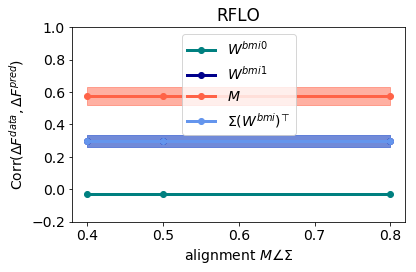

In [7]:
""" Same plot using flow field """
paper = False
save = False


fig,ax = plt.subplots(1,1,figsize=(6,4))

n_samples = len(stats['corr1'])
mn1 = np.mean(np.asarray(stats['corr1']),axis=0)
std1 = np.std(np.asarray(stats['corr1']),axis=0)
sem1 = std1/np.sqrt(n_samples)

mn2 = np.mean(np.asarray(stats['corr2']),axis=0)
std2 = np.std(np.asarray(stats['corr2']),axis=0)
sem2 = std2/np.sqrt(n_samples)

mn3 = np.mean(np.asarray(stats['corr3']),axis=0)
std3 = np.std(np.asarray(stats['corr3']),axis=0)
sem3 = std3/np.sqrt(n_samples)

mn4 = np.mean(np.asarray(stats['corr4']),axis=0)
std4 = np.std(np.asarray(stats['corr4']),axis=0)
sem4 = std4/np.sqrt(n_samples)

plt.plot(overlaps,mn1,'o-',linewidth=3,label=r'$W^{bmi0}$',color='teal')
plt.fill_between(overlaps,mn1-sem1,mn1+sem1,alpha=0.5,color='teal')


plt.plot(overlaps,mn2,'o-',linewidth=3,label=r'$W^{bmi1}$',color='darkblue')
plt.fill_between(overlaps,mn2-sem2,mn2+sem2,alpha=0.5,color='darkblue')

plt.plot(overlaps,mn3,'o-',linewidth=3,label=r'$ M$',color='tomato')
plt.fill_between(overlaps,mn3-sem3,mn3+sem3,alpha=0.5,color='tomato')

plt.plot(overlaps,mn4,'o-',linewidth=3,label=r'$\Sigma (W^{bmi})^\top$',color='cornflowerblue')
plt.fill_between(overlaps,mn4-sem4,mn4+sem4,alpha=0.5,color='cornflowerblue')

plt.ylim([-0.2,1])
plt.legend()
plt.title('RFLO')
plt.xlabel('alignment '+r'$M \angle \Sigma$')
plt.ylabel('Corr'+r'$(\Delta F^{data}, \Delta F^{pred})$')

plt.tight_layout()

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=[0.25,0.5,0.75,1],ylabels=[0,0.25,0.5,0.75,1],ticksize=10,linewidth=2,ylim=[-.2,1],figsize=(2.25,3))

plt.show()

if save:
    if paper:
        fig.savefig(folder+'rflo-dF-change-m.pdf')
    else:
        fig.savefig(folder+'rflo-dF-change-m_v2.pdf')


# low-D noise, REINFORCE

The experiment here is setup as follows:

1. Pretrain with w_out0
2. Choose new decoder w_out1, that has partial overlap with w_out0

3A. Choose some matrix w_m_sigma that has partial overlap with **w_out1**, the new decoder. Vary this overlap
    - this learns well, but doesn't lead to different distinctions wrt the metric

3B. Choose some matrix w_m that has high overlap (e.g. 0.8) with **w_out1**, the new decoder. Then vary the overlap between w_m and some w_m_sigma that is used to construct Sigma
    - this seems to learn well and also has slightly distinct metric values


4. Define a low-D (i.e. rank 2) covariance matrix $\Sigma$ based on w_m_sigma by doing QR decomposition. Use this covariance matrix to generate recurrent noise

3it [00:00, 27.26it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.25
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.2
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fe522006e10>


2500it [00:28, 87.73it/s]



~~~~ OVERLAP 0.4, SEED 55


M norm: 0.85	 M angle: 0.75, 3 iterations
w_out1 norm: 1.50	 w_out vs. w_out1 angle: 0.51
w_m norm: 0.85	 w_out1 vs. w_m angle: 0.75
M norm: 1.24	 M angle: 0.40, 39 iterations
 w_m vs. w_m_sigma angle: 0.24
 w_out1 vs. w_m_sigma angle: 0.40

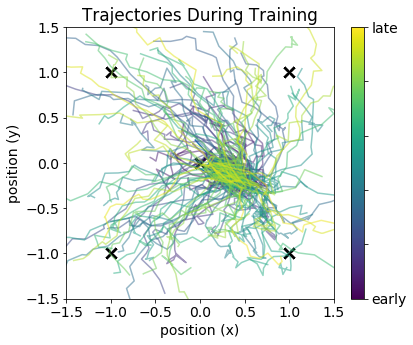

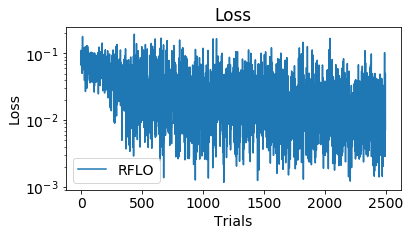

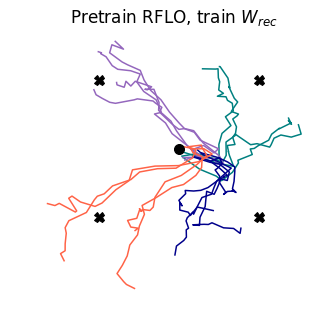

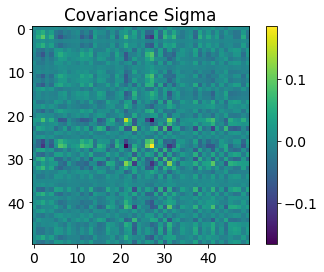

1000it [00:10, 97.04it/s]
5000it [01:28, 56.66it/s]
1000it [00:12, 80.48it/s]


AR early fit 0.986, late fit 0.992


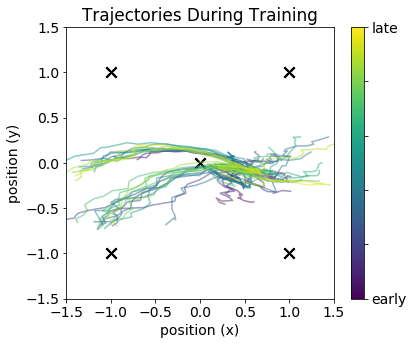

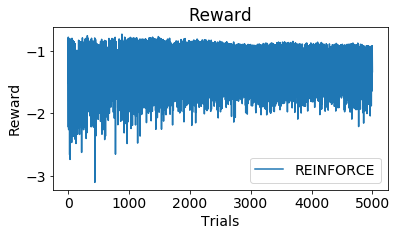

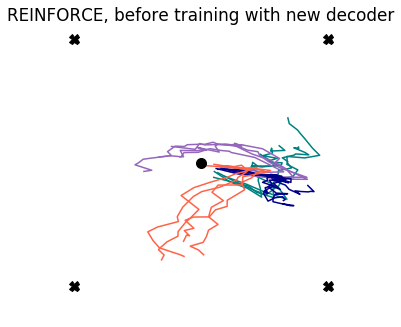

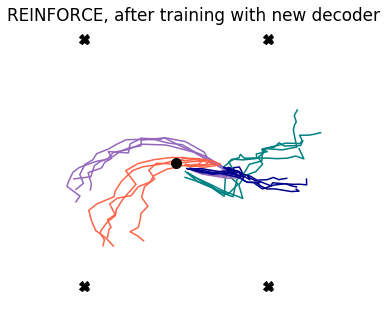

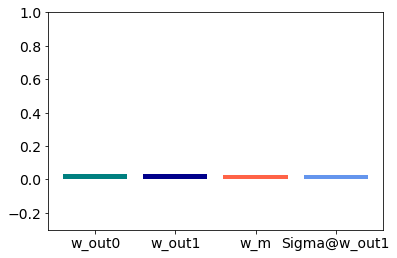


~~~~ OVERLAP 0.6, SEED 55


M norm: 0.85	 M angle: 0.75, 3 iterations
w_out1 norm: 1.50	 w_out vs. w_out1 angle: 0.51
w_m norm: 0.85	 w_out1 vs. w_m angle: 0.75
M norm: 1.05	 M angle: 0.60, 3 iterations
 w_m vs. w_m_sigma angle: 0.45
 w_out1 vs. w_m_sigma angle: 0.60

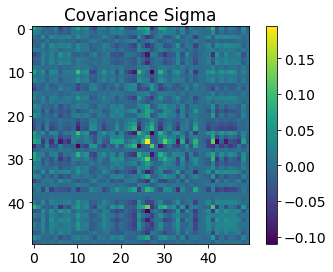

1000it [00:12, 81.06it/s]
5000it [01:07, 73.90it/s]
1000it [00:11, 90.21it/s]


AR early fit 0.985, late fit 0.993


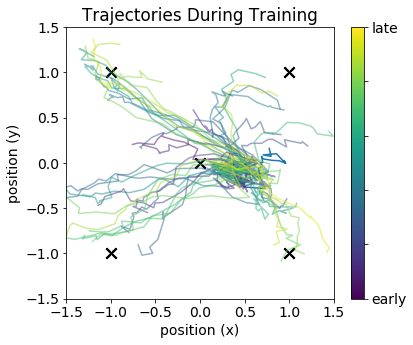

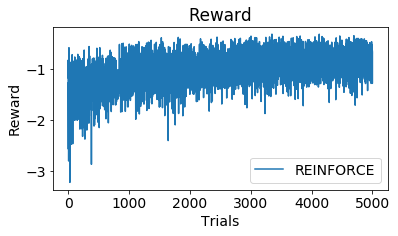

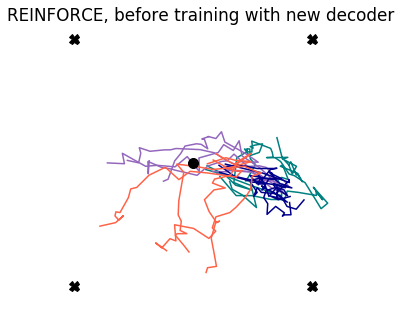

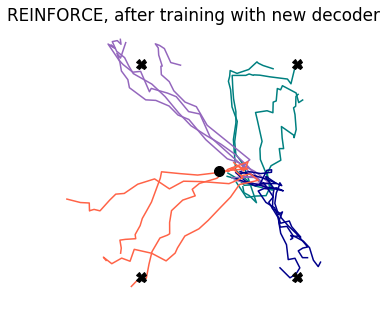

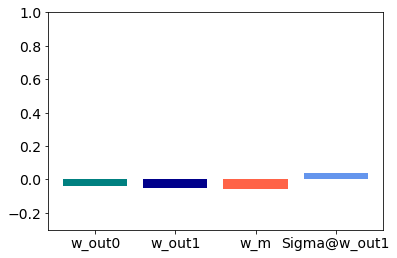


~~~~ OVERLAP 0.8, SEED 55


M norm: 0.85	 M angle: 0.75, 3 iterations
w_out1 norm: 1.50	 w_out vs. w_out1 angle: 0.51
w_m norm: 0.85	 w_out1 vs. w_m angle: 0.75
M norm: 0.78	 M angle: 0.80, 0 iterations
 w_m vs. w_m_sigma angle: 0.61
 w_out1 vs. w_m_sigma angle: 0.80

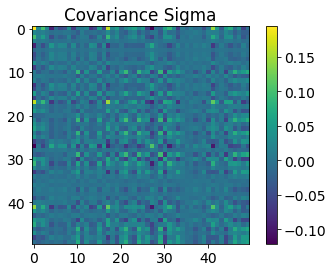

1000it [00:09, 101.25it/s]
5000it [01:03, 78.23it/s]
1000it [00:10, 94.02it/s]


AR early fit 0.986, late fit 0.995


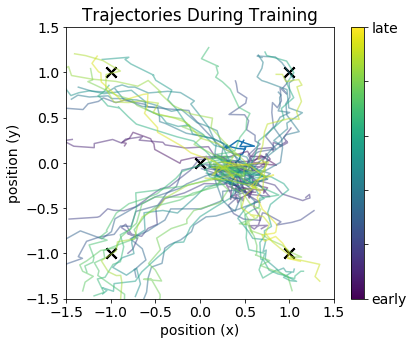

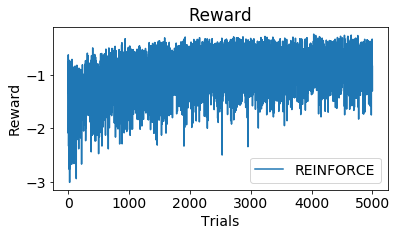

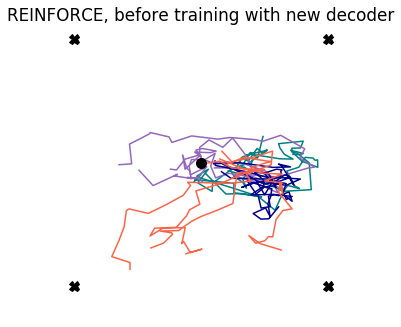

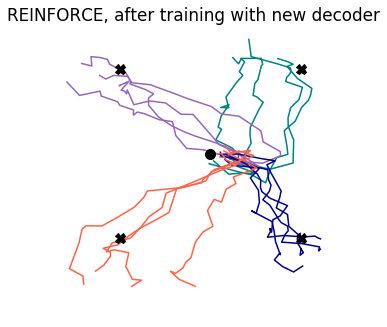

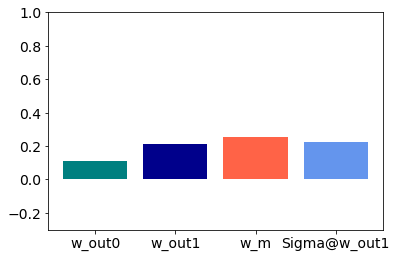


~~~~ OVERLAP 0.4, SEED 72


M norm: 0.90	 M angle: 0.74, 1 iterations
w_out1 norm: 1.52	 w_out vs. w_out1 angle: 0.50
w_m norm: 0.90	 w_out1 vs. w_m angle: 0.74
M norm: 1.34	 M angle: 0.39, 13 iterations
 w_m vs. w_m_sigma angle: 0.32
 w_out1 vs. w_m_sigma angle: 0.39

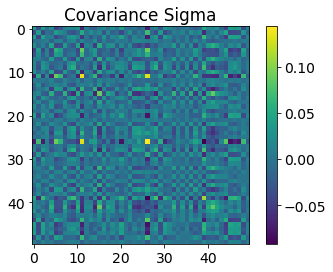

1000it [00:10, 97.10it/s]
5000it [01:03, 78.31it/s]
1000it [00:11, 90.22it/s]


AR early fit 0.984, late fit 0.994


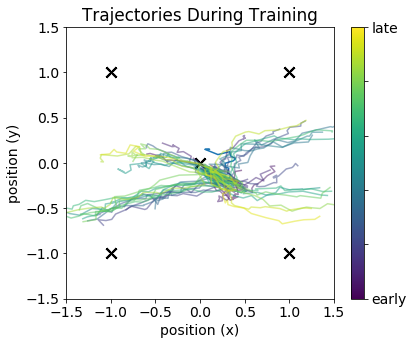

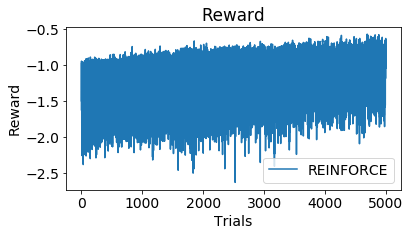

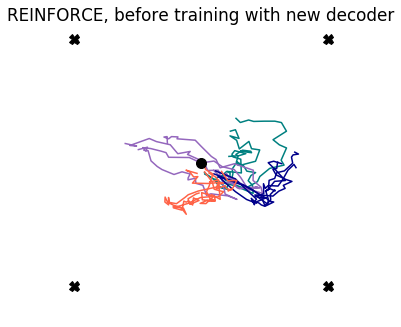

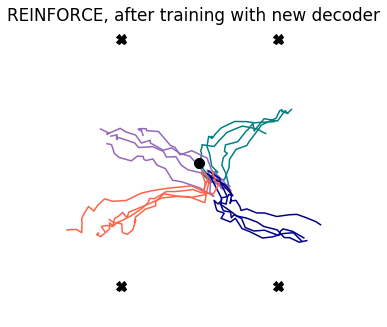

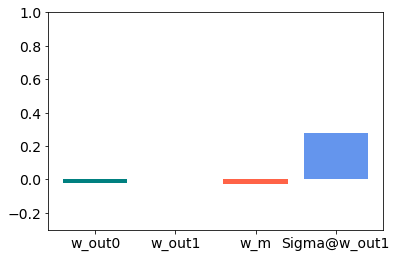


~~~~ OVERLAP 0.6, SEED 72


M norm: 0.90	 M angle: 0.74, 1 iterations
w_out1 norm: 1.52	 w_out vs. w_out1 angle: 0.50
w_m norm: 0.90	 w_out1 vs. w_m angle: 0.74
M norm: 1.09	 M angle: 0.61, 12 iterations
 w_m vs. w_m_sigma angle: 0.48
 w_out1 vs. w_m_sigma angle: 0.61

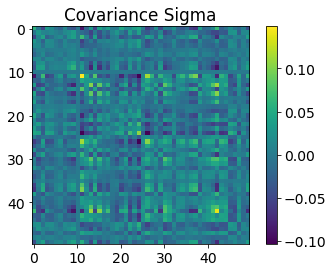

1000it [00:11, 87.05it/s]
5000it [01:02, 79.67it/s]
1000it [00:12, 80.72it/s]


AR early fit 0.985, late fit 0.995


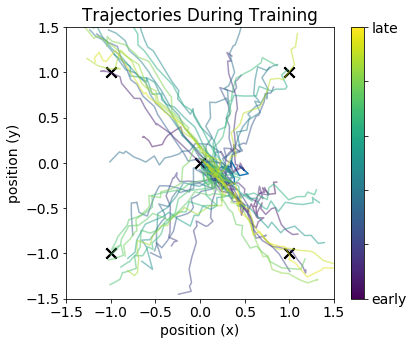

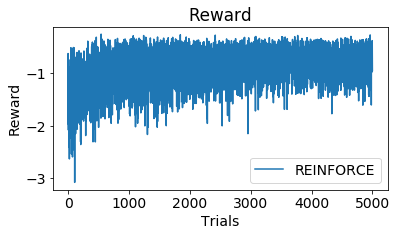

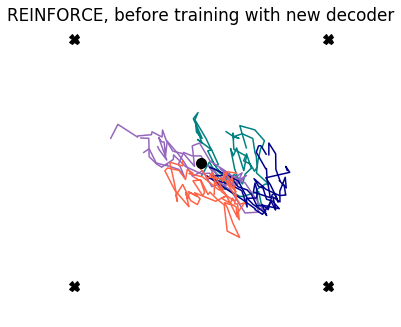

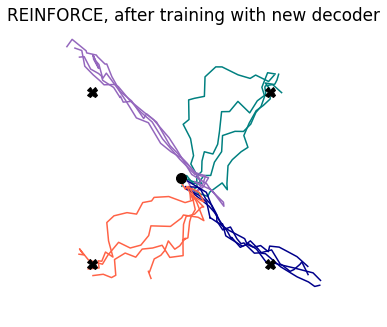

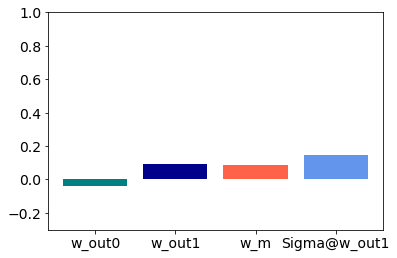


~~~~ OVERLAP 0.8, SEED 72


M norm: 0.90	 M angle: 0.74, 1 iterations
w_out1 norm: 1.52	 w_out vs. w_out1 angle: 0.50
w_m norm: 0.90	 w_out1 vs. w_m angle: 0.74
M norm: 0.83	 M angle: 0.79, 10 iterations
 w_m vs. w_m_sigma angle: 0.50
 w_out1 vs. w_m_sigma angle: 0.79

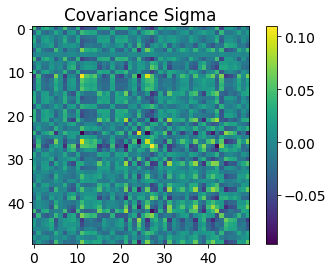

1000it [00:10, 98.59it/s]
5000it [01:02, 80.56it/s]
1000it [00:10, 99.77it/s]


AR early fit 0.985, late fit 0.994


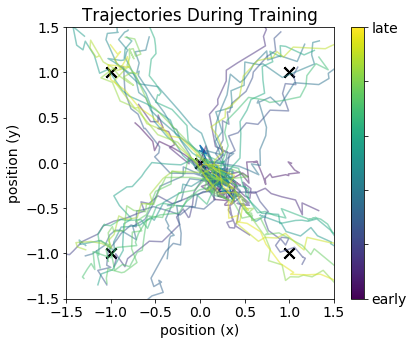

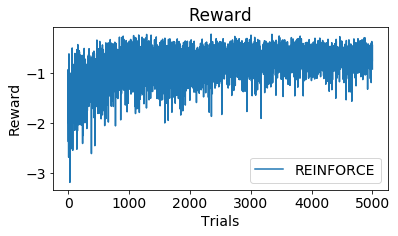

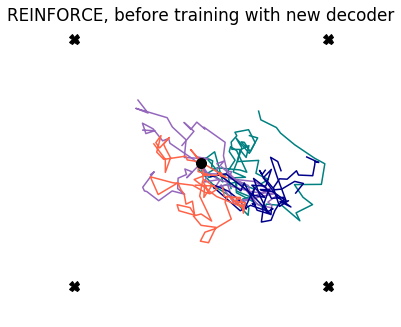

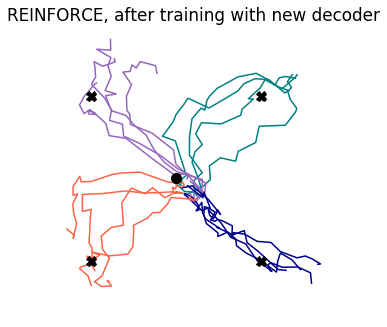

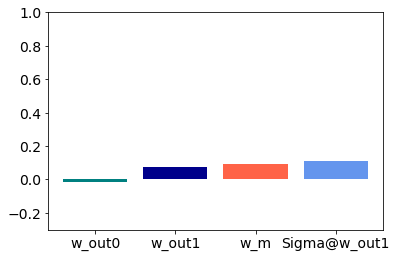

In [33]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.2,eta_out=0.1,
               sig_in=0.0,sig_rec=0.25,sig_out=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               rng=np.random.RandomState(72))
params.print_params()

""" Average over multiple seeds """

# seeds = [0,22,33,47] #,54,72,81]
# overlaps = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
# n_changes = [75,75,60,50,50,50,30,30,1]
#overlaps = [0.4,0.5,0.6,0.7,0.8,0.9]
#n_changes = [60,50,50,40,30,5]
seeds=[55,72]

""" vary overlap between w_out and w_m_sigma that generates covariance matrix """
overlaps = [0.4,0.6,0.8]
n_changes = [60,50,30]

overlap_w_out0 = 0.5
n_change_w_out0 = 50
pretrain_duration = 2500
train_duration=5000

overlap_w_m = 0.75 # We want W_m to be the same as wbmi1 here, so learning can occur with REINFORCE
n_change_w_m = 30

vary_sigma_wout1 = True


# Initialize RNN, train with RFLO
net0 = RNN(params)
sim0 = Simulation(net0)
rflo = RFLO(net0,apply_to=['w_rec'],online=False)
sim0.run_session(n_trials=pretrain_duration, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=20)

fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='Pretrain RFLO, train '+r'$W_{rec}$')









stats = {}
stats['corr1'] = []
stats['corr2'] = []
stats['corr3'] = []
stats['corr4'] = []
stats['corrcoef'] = []


stats['seeds'] = seeds
stats['overlaps'] = overlaps
stats['overlap_w_m'] = overlap_w_m


for seed in seeds:

    corr1_list = []
    corr2_list = []
    corr3_list = []
    corr4_list = []
    corrcoef_list = []
    

    for overlap,n_change in zip(overlaps,n_changes):
        
        print('\n~~~~ OVERLAP {}, SEED {}'.format(overlap,seed))
        print('\n')
        
        """ choose new decoder w_out1, change overlap """
        w_out1 = choose_aligned_matrix(net0.w_out.copy(),n_change=n_change_w_out0,overlap=overlap_w_out0,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
        """ choose new internal model w_m, keep constant """
        w_m = choose_aligned_matrix(w_out1.copy(),n_change=n_change_w_m,overlap=overlap_w_m,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)

        
        # confirm overlap between w_out1 and w_out
        norm, angle = return_norm_and_angle(net0.w_out,w_out1)
        print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out1 and w_m
        norm, angle = return_norm_and_angle(w_out1,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out1 vs. w_m angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out and w_m
        norm, angle = return_norm_and_angle(net0.w_out,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out vs. w_m angle: {:.2f}'.format(angle),end='')
        
        
        
        """ Version 1 - use w_m, find sigma that is partially aligned, and generate covariance matrix """
        w_m_sigma = choose_aligned_matrix(w_m,n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
        
        """ Version 2 - Use w_out1, find sigma that is partially aligned, and generate covariance matrix """
        if vary_sigma_wout1:
            w_m_sigma = choose_aligned_matrix(w_out1,n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
        
        
        _, angle = return_norm_and_angle(w_m,w_m_sigma)
        print('\n w_m vs. w_m_sigma angle: {:.2f}'.format(angle),end='')
        _, angle = return_norm_and_angle(w_out1,w_m_sigma)
        print('\n w_out1 vs. w_m_sigma angle: {:.2f}'.format(angle),end='')
        
        
        """ Choose Noise Covariance """
        Q,R = LA.qr(w_m_sigma.T)
        u0 = Q[:,0]
        u1 = Q[:,1]

        Sigma = np.outer(u0,u0) + np.outer(u1,u1)
        fig,ax = plt.subplots(1,1)
        plt.imshow(Sigma)
        plt.title('Covariance Sigma')
        plt.colorbar()
        plt.show()
        
        
        net2_pre = RNN(params,sig_rec_covariance=Sigma)
        net2_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net2_pre.set_weights(w_out = w_out1)
        net2_pre.set_weights(w_m = 0*w_m.T) # shouldn't matter for REINFORCE

        # unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
        net2 = RNN(params,sig_rec_covariance=Sigma)
        net2.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net2.set_weights(w_out = w_out1)
        net2.set_weights(w_m = 0*w_m.T) # shouldn't matter for REINFORCE



        """ Track activity with new decoder, before training """

        sim2_pre = Simulation(net2_pre)
        trackvars = TrackVars(net2_pre,apply_to=[]) 
        sim2_pre.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
        #fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        """ Train with new decoder """

        sim2_train = Simulation(net2)
        reinforce = REINFORCE(net2,apply_to=['w_rec'],online=False,tau_reward=5)
        sim2_train.run_session(n_trials=train_duration, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['h','reward','err'], plot=True, plot_freq=100)

        """ Track activity with new decoder, after training """
        net2_post = RNN(params,sig_rec_covariance=Sigma)
        net2_post.set_weights(w_in=net2.w_in.copy(), w_rec=net2.w_rec.copy())
        net2_post.set_weights(w_out = net2.w_out)
        net2_post.set_weights(w_m = 0*net2.w_m) # shouldn't matter for REINFORCE

        sim2_post = Simulation(net2_post)
        trackvars = TrackVars(net2_post,apply_to=[]) 
        sim2_post.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)

        
        fig = plot_trained_trajectories(sim=sim2_pre, tasks=[task1,task2,task3,task4],title='REINFORCE, before training with new decoder')

        fig = plot_trained_trajectories(sim=sim2_post, tasks=[task1,task2,task3,task4],title='REINFORCE, after training with new decoder')
        
        
        """ Calculate F fields """
        F_early, score_early = flow_field_data(sim2_pre.session_probes['h'])
        F_late, score_late = flow_field_data(sim2_post.session_probes['h'])

        print('AR early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

        Fdata = F_late - F_early

        # separate train and test data from sim1_train
        n_total = len(sim2_train.session_probes['h'])
        n_train = int(0.5 * n_total)
        idx_train = np.random.RandomState(1975+seed).choice(np.arange(0,n_total),size=n_train,replace=False).astype(int)
        idx_test = np.arange(0,n_total)[~idx_train].astype(int)
        #idx_test=idx_train

        h_train = np.asarray(sim2_train.session_probes['h'])[idx_train,:,:,:]
        err_train = np.asarray(sim2_train.session_probes['err'])[idx_train,:,:,:]

        Fpred_w_out = flow_field_predicted(net0.w_out,err_train,h_train)
        Fpred_w_out1 = flow_field_predicted(w_out1,err_train,h_train)
        Fpred_w_m = flow_field_predicted(w_m,err_train,h_train)
        Fpred_cov_w_out1 = flow_field_predicted(w_out1@Sigma.T,err_train,h_train) # nonisotropic noise, wout1 is tranposed inside function

        h_test = np.asarray(sim2_train.session_probes['h'])[idx_test,:,:,:]

        corr1 = calculate_flow_field_correlation(Fpred_w_out,Fdata,h_test) # could also sample sim_test
        corr1_list.append(corr1)

        corr2 = calculate_flow_field_correlation(Fpred_w_out1,Fdata,h_test) # could also sample sim_test
        corr2_list.append(corr2)

        corr3 = calculate_flow_field_correlation(Fpred_w_m,Fdata,h_test) # could also sample sim_test
        corr3_list.append(corr3)
        
        corr4 = calculate_flow_field_correlation(Fpred_cov_w_out1,Fdata,h_test) # could also sample sim_test
        corr4_list.append(corr4)
        
        fig,ax = plt.subplots(1,1)
        plt.bar([0,1,2,3],[corr1,corr2,corr3,corr4],tick_label=['w_out0','w_out1','w_m','Sigma@w_out1'],color=['teal','darkblue','tomato','cornflowerblue'])
        plt.ylim([-0.3,1])
        plt.show()
        
        
        
        
        
        
    # update
    stats['corr1'].append(corr1_list)
    stats['corr2'].append(corr2_list)
    stats['corr3'].append(corr3_list)
    stats['corr4'].append(corr4_list)
    #stats['corrcoef'].append(corrcoef_list)
    


In [ ]:
stats_reinforce_noniso = stats
stats_reinforce_noniso['params']=params

""" save stats """
save = False

if save:
    
    with open(folder+'stats_reinforce_noniso_'+seeds+'.pickle', 'wb') as handle:
        pickle.dump(stats_reinforce_noniso, handle, protocol=pickle.HIGHEST_PROTOCOL)


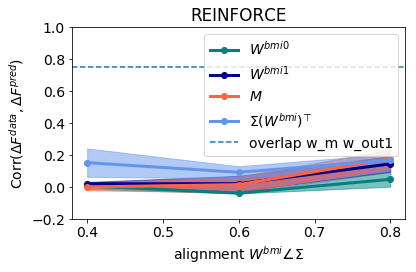

In [37]:
""" Same plot using flow field """
paper = False
save = False


fig,ax = plt.subplots(1,1,figsize=(6,4))

n_samples = len(stats['corr1'])
mn1 = np.mean(np.asarray(stats['corr1']),axis=0)
std1 = np.std(np.asarray(stats['corr1']),axis=0)
sem1 = std1/np.sqrt(n_samples)

mn2 = np.mean(np.asarray(stats['corr2']),axis=0)
std2 = np.std(np.asarray(stats['corr2']),axis=0)
sem2 = std2/np.sqrt(n_samples)

mn3 = np.mean(np.asarray(stats['corr3']),axis=0)
std3 = np.std(np.asarray(stats['corr3']),axis=0)
sem3 = std3/np.sqrt(n_samples)

mn4 = np.mean(np.asarray(stats['corr4']),axis=0)
std4 = np.std(np.asarray(stats['corr4']),axis=0)
sem4 = std4/np.sqrt(n_samples)

plt.plot(overlaps,mn1,'o-',linewidth=3,label=r'$W^{bmi0}$',color='teal')
plt.fill_between(overlaps,mn1-sem1,mn1+sem1,alpha=0.5,color='teal')


plt.plot(overlaps,mn2,'o-',linewidth=3,label=r'$W^{bmi1}$',color='darkblue')
plt.fill_between(overlaps,mn2-sem2,mn2+sem2,alpha=0.5,color='darkblue')

plt.plot(overlaps,mn3,'o-',linewidth=3,label=r'$ M$',color='tomato')
plt.fill_between(overlaps,mn3-sem3,mn3+sem3,alpha=0.5,color='tomato')

plt.plot(overlaps,mn4,'o-',linewidth=3,label=r'$\Sigma (W^{bmi})^\top$',color='cornflowerblue')
plt.fill_between(overlaps,mn4-sem4,mn4+sem4,alpha=0.5,color='cornflowerblue')

plt.axhline(y=overlap_w_m,linestyle='--',label='overlap w_m w_out1')
plt.ylim([-0.2,1])
plt.legend()
plt.title('REINFORCE')
#plt.xlabel('alignment '+r'$M \angle W^{bmi1}$')
plt.xlabel('alignment '+r'$W^{bmi} \angle \Sigma$')
plt.ylabel('Corr'+r'$(\Delta F^{data}, \Delta F^{pred})$')

plt.tight_layout()

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=[0.2,0.4,0.6,0.8,1],ylabels=[0,0.2,0.4,0.6],ticksize=10,linewidth=2,ylim=[-.2,0.6],figsize=(2.25,3),labelsize=10)

plt.show()

if save:
    if paper:
        fig.savefig(folder+'reinforce-dF-noniso-example.pdf')
    else:
        fig.savefig(folder+'reinforce-dF-noniso-example.pdf')


In [36]:
len(stats['corr1'])

2

# Part 3 - RFLO with Sigma of increasing dimensions

Here is my little script for generating the covariance:

```
""" Choose Noise Covariance """
Q,R = LA.qr(w_m_sigma.T)
u0 = Q[:,0]
u1 = Q[:,1]
Sigma = np.outer(u0,u0) + np.outer(u1,u1)

for d in range(2,dim):
    u = Q[:,d]
    Sigma += np.outer(u,u)

"""multiply by sig_rec (since I don't do this in code)"""
Sigma *= net0.sig_rec
```

In [5]:
trial_duration = 20
n_in=4
frac_on = 0.2

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

7it [00:00, 66.74it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.25
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.2
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fafa51113f0>


2500it [00:29, 83.56it/s]


M norm: 1.13	 M angle: 0.50, 5 iterations
w_out1 norm: 1.50	 w_out vs. w_out1 angle: 0.50
w_m norm: 1.13	 w_out1 vs. w_m angle: 0.50
M norm: 0.00	 M angle: 1.00, 0 iterations
 w_m vs. w_m_sigma angle: 1.00
 w_out1 vs. w_m_sigma angle: 0.50

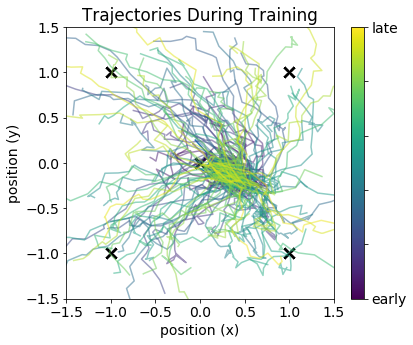

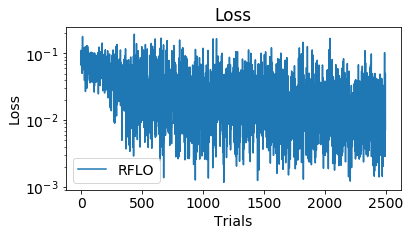

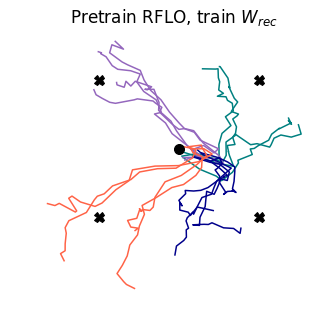

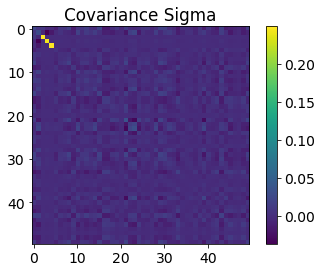

500it [00:05, 87.90it/s]
1000it [00:15, 65.85it/s]
500it [00:04, 106.52it/s]


AR early fit 0.988, late fit 0.994


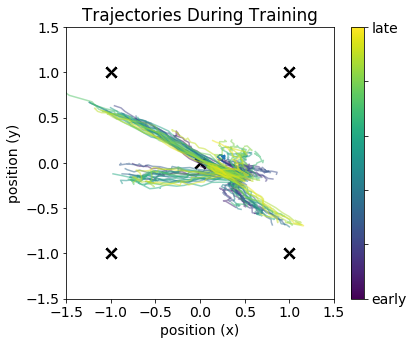

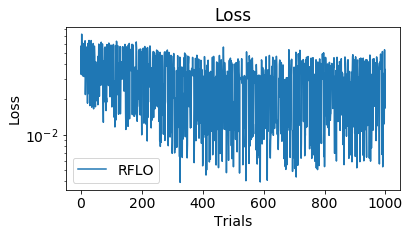

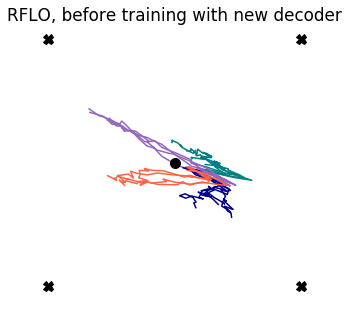

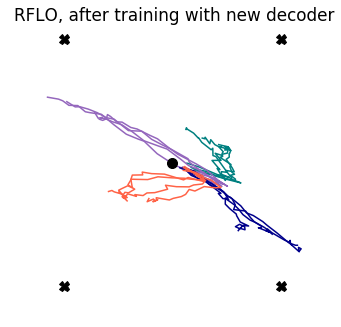

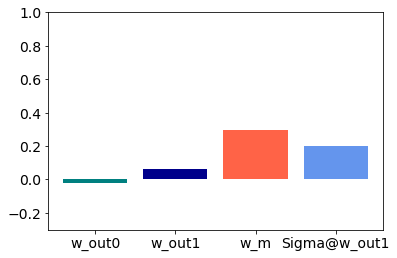

M norm: 1.13	 M angle: 0.50, 5 iterations
w_out1 norm: 1.50	 w_out vs. w_out1 angle: 0.50
w_m norm: 1.13	 w_out1 vs. w_m angle: 0.50
M norm: 0.00	 M angle: 1.00, 0 iterations
 w_m vs. w_m_sigma angle: 1.00
 w_out1 vs. w_m_sigma angle: 0.50

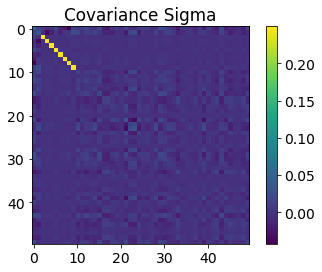

500it [00:04, 105.32it/s]
1000it [00:11, 87.65it/s]
500it [00:04, 106.26it/s]


AR early fit 0.976, late fit 0.990


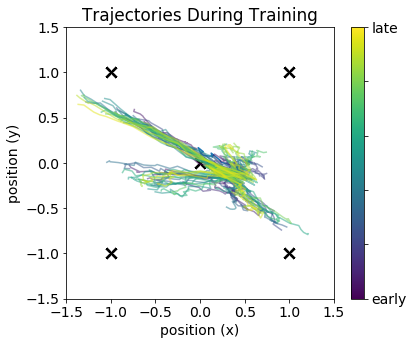

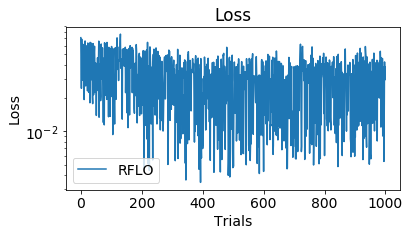

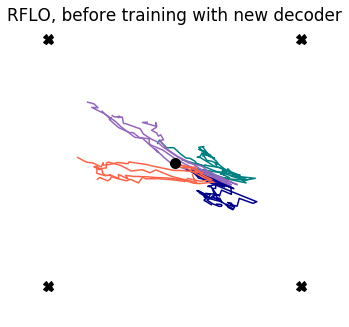

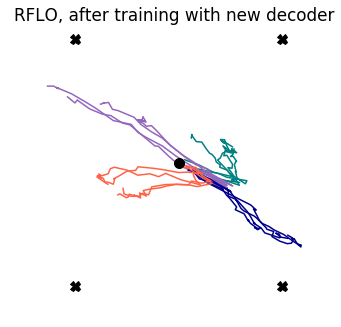

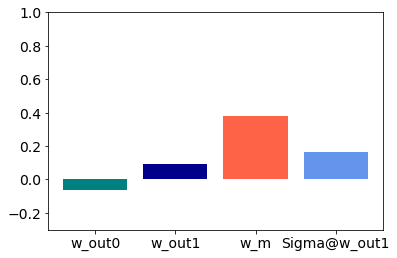

M norm: 1.13	 M angle: 0.50, 5 iterations
w_out1 norm: 1.50	 w_out vs. w_out1 angle: 0.50
w_m norm: 1.13	 w_out1 vs. w_m angle: 0.50
M norm: 0.00	 M angle: 1.00, 0 iterations
 w_m vs. w_m_sigma angle: 1.00
 w_out1 vs. w_m_sigma angle: 0.50

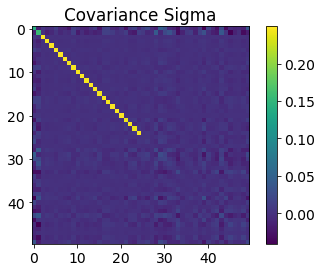

500it [00:04, 100.05it/s]
1000it [00:14, 67.44it/s]
500it [00:06, 79.42it/s]


AR early fit 0.957, late fit 0.980


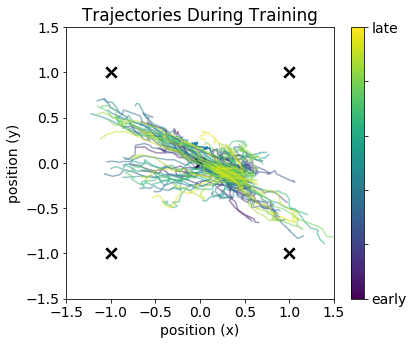

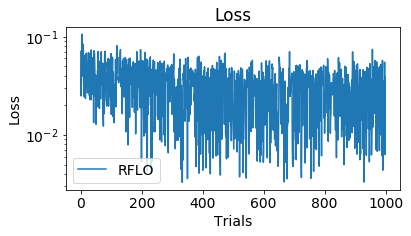

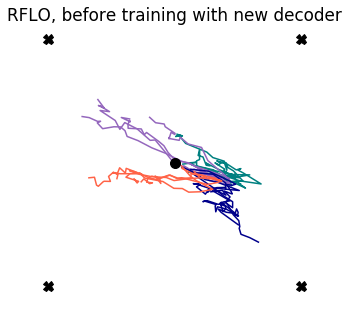

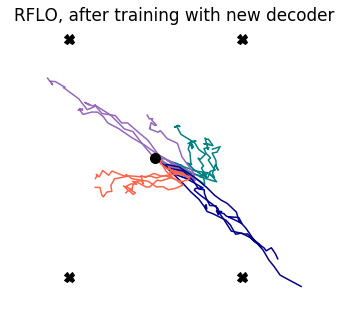

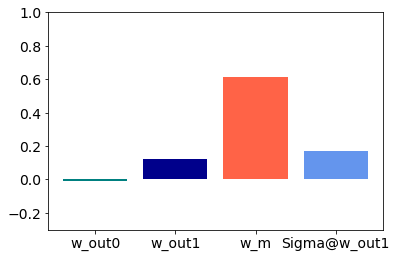

M norm: 1.13	 M angle: 0.50, 5 iterations
w_out1 norm: 1.50	 w_out vs. w_out1 angle: 0.50
w_m norm: 1.13	 w_out1 vs. w_m angle: 0.50
M norm: 0.00	 M angle: 1.00, 0 iterations
 w_m vs. w_m_sigma angle: 1.00
 w_out1 vs. w_m_sigma angle: 0.50

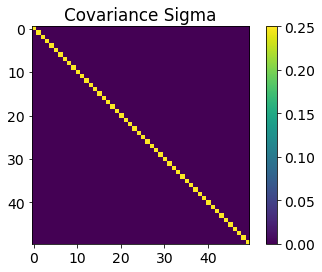

500it [00:05, 94.67it/s]
1000it [00:14, 65.28it/s]
500it [00:05, 93.90it/s]


AR early fit 0.936, late fit 0.965


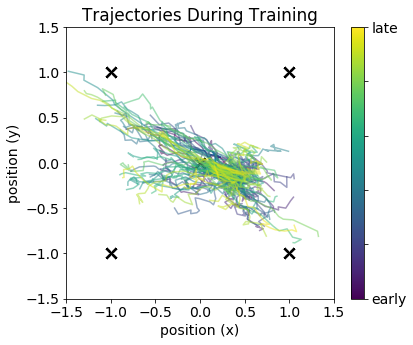

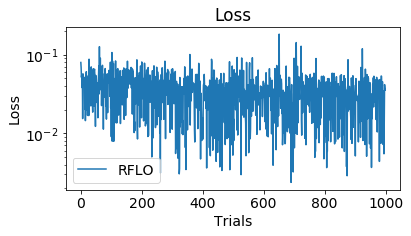

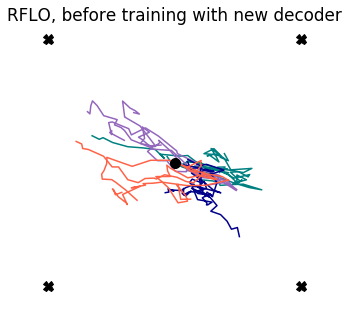

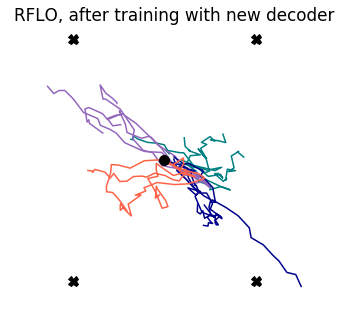

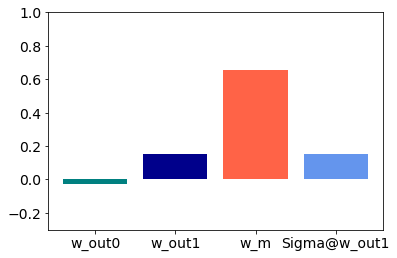

M norm: 1.15	 M angle: 0.49, 4 iterations
w_out1 norm: 1.50	 w_out vs. w_out1 angle: 0.51
w_m norm: 1.15	 w_out1 vs. w_m angle: 0.49
M norm: 0.00	 M angle: 1.00, 0 iterations
 w_m vs. w_m_sigma angle: 1.00
 w_out1 vs. w_m_sigma angle: 0.49

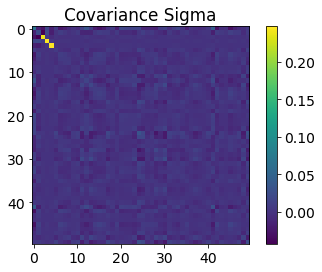

500it [00:06, 82.20it/s]
1000it [00:12, 81.57it/s]
500it [00:04, 113.67it/s]


AR early fit 0.987, late fit 0.995


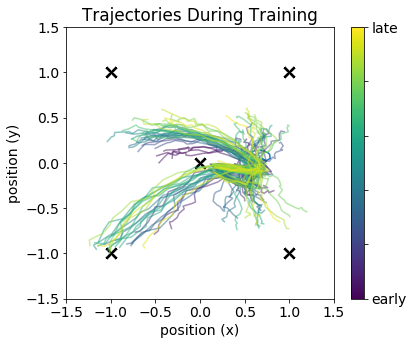

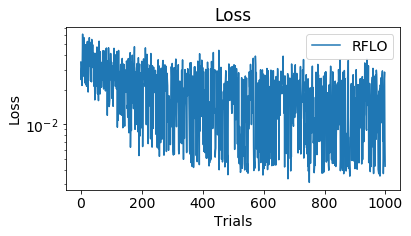

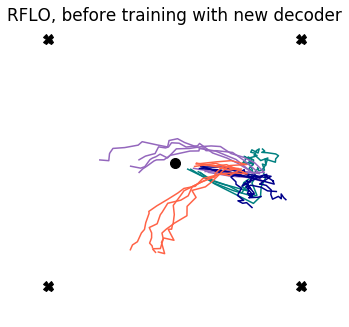

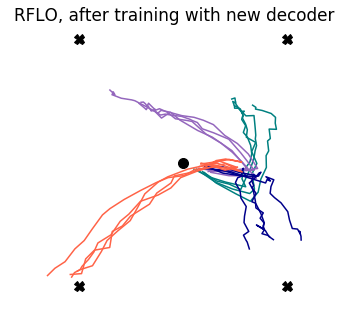

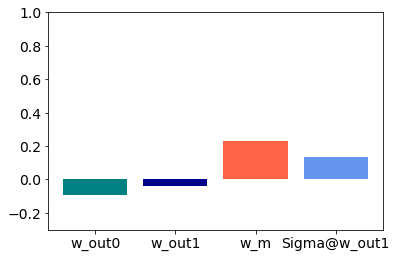

M norm: 1.15	 M angle: 0.49, 4 iterations
w_out1 norm: 1.50	 w_out vs. w_out1 angle: 0.51
w_m norm: 1.15	 w_out1 vs. w_m angle: 0.49
M norm: 0.00	 M angle: 1.00, 0 iterations
 w_m vs. w_m_sigma angle: 1.00
 w_out1 vs. w_m_sigma angle: 0.49

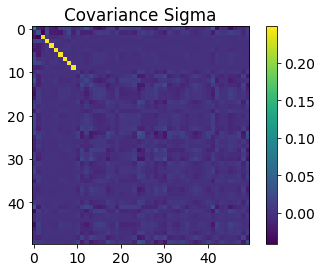

500it [00:04, 106.45it/s]
1000it [00:11, 86.31it/s]
500it [00:05, 92.80it/s]


AR early fit 0.977, late fit 0.990


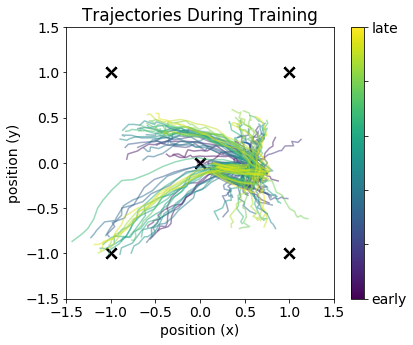

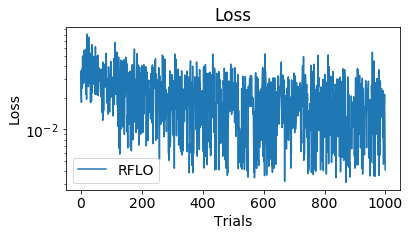

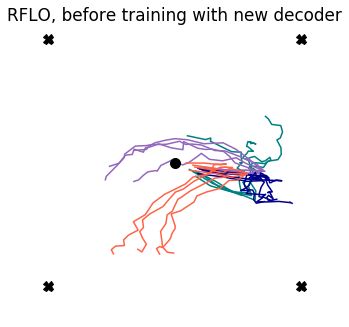

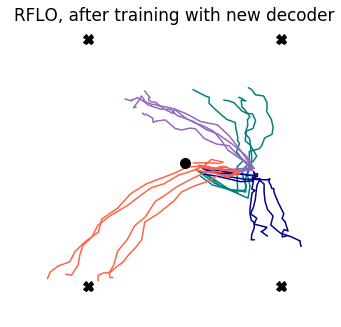

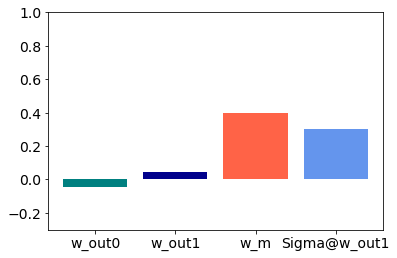

M norm: 1.15	 M angle: 0.49, 4 iterations
w_out1 norm: 1.50	 w_out vs. w_out1 angle: 0.51
w_m norm: 1.15	 w_out1 vs. w_m angle: 0.49
M norm: 0.00	 M angle: 1.00, 0 iterations
 w_m vs. w_m_sigma angle: 1.00
 w_out1 vs. w_m_sigma angle: 0.49

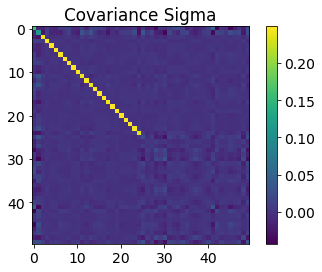

500it [00:06, 90.99it/s]
1000it [00:14, 67.91it/s]
500it [00:06, 82.84it/s]


AR early fit 0.957, late fit 0.979


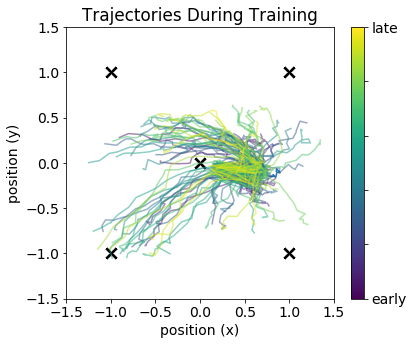

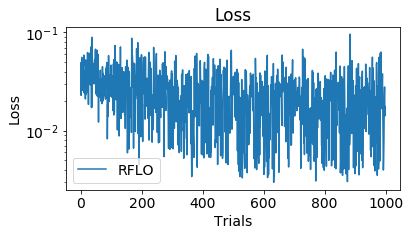

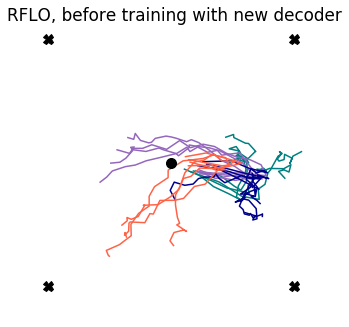

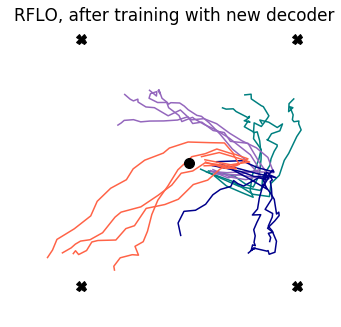

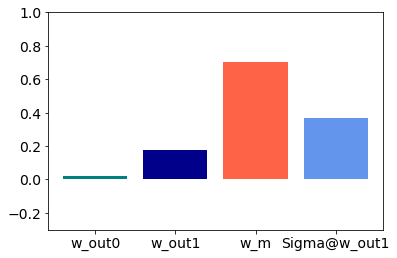

M norm: 1.15	 M angle: 0.49, 4 iterations
w_out1 norm: 1.50	 w_out vs. w_out1 angle: 0.51
w_m norm: 1.15	 w_out1 vs. w_m angle: 0.49
M norm: 0.00	 M angle: 1.00, 0 iterations
 w_m vs. w_m_sigma angle: 1.00
 w_out1 vs. w_m_sigma angle: 0.49

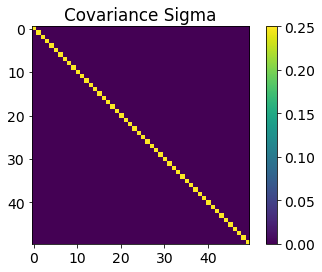

500it [00:05, 86.23it/s]
1000it [00:13, 75.57it/s]
500it [00:05, 96.38it/s]


AR early fit 0.935, late fit 0.964


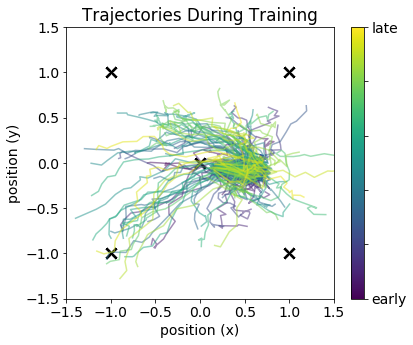

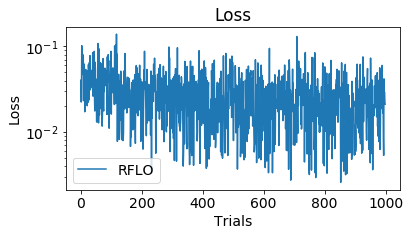

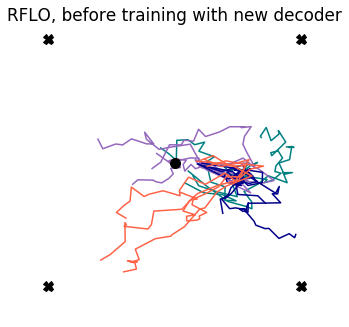

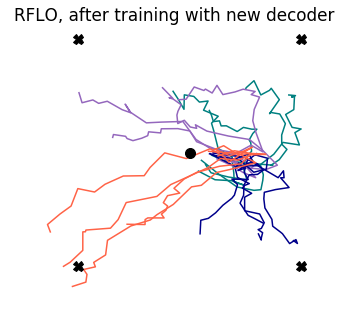

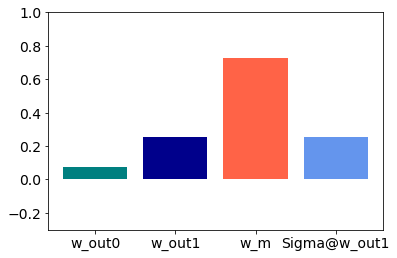

M norm: 1.17	 M angle: 0.50, 57 iterations
w_out1 norm: 1.52	 w_out vs. w_out1 angle: 0.49
w_m norm: 1.17	 w_out1 vs. w_m angle: 0.50
M norm: 0.00	 M angle: 1.00, 0 iterations
 w_m vs. w_m_sigma angle: 1.00
 w_out1 vs. w_m_sigma angle: 0.50

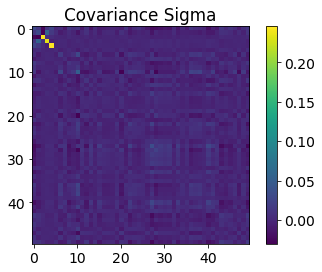

500it [00:05, 92.27it/s]
1000it [00:12, 80.19it/s]
500it [00:05, 98.77it/s]


AR early fit 0.988, late fit 0.993


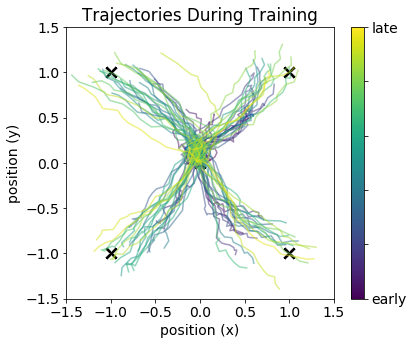

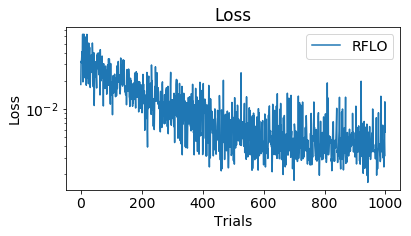

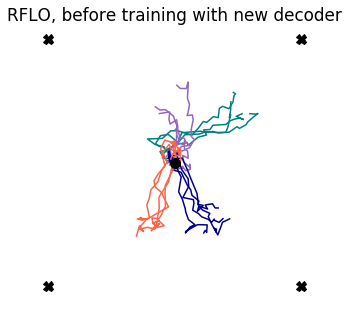

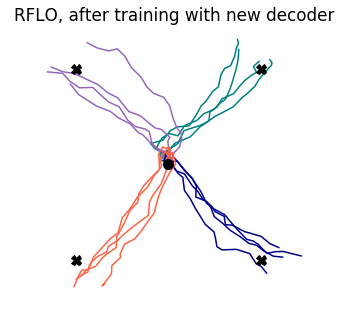

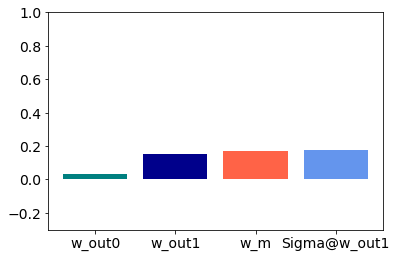

M norm: 1.17	 M angle: 0.50, 57 iterations
w_out1 norm: 1.52	 w_out vs. w_out1 angle: 0.49
w_m norm: 1.17	 w_out1 vs. w_m angle: 0.50
M norm: 0.00	 M angle: 1.00, 0 iterations
 w_m vs. w_m_sigma angle: 1.00
 w_out1 vs. w_m_sigma angle: 0.50

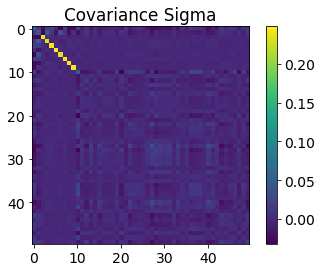

500it [00:05, 97.11it/s]
1000it [00:12, 78.97it/s]
500it [00:05, 96.21it/s]


AR early fit 0.977, late fit 0.988


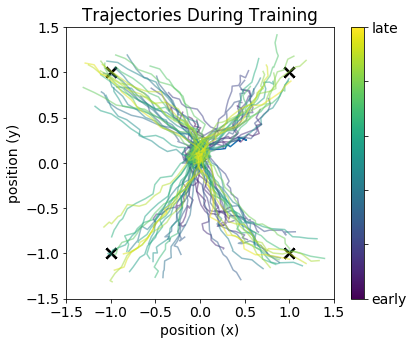

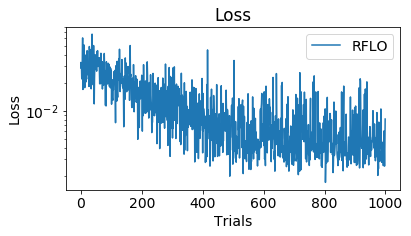

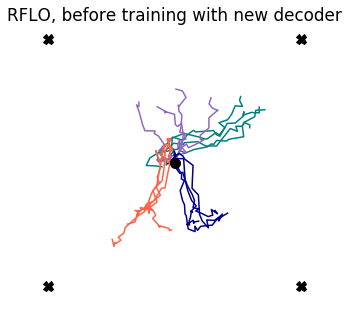

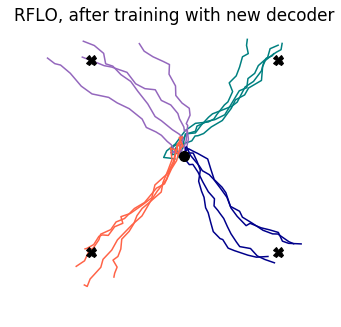

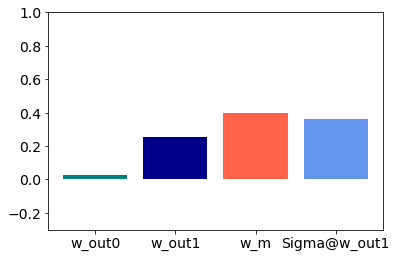

M norm: 1.17	 M angle: 0.50, 57 iterations
w_out1 norm: 1.52	 w_out vs. w_out1 angle: 0.49
w_m norm: 1.17	 w_out1 vs. w_m angle: 0.50
M norm: 0.00	 M angle: 1.00, 0 iterations
 w_m vs. w_m_sigma angle: 1.00
 w_out1 vs. w_m_sigma angle: 0.50

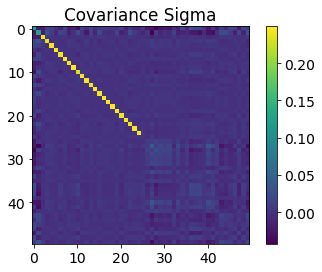

500it [00:06, 80.33it/s]
1000it [00:12, 73.66it/s]
500it [00:05, 84.81it/s]


AR early fit 0.957, late fit 0.976


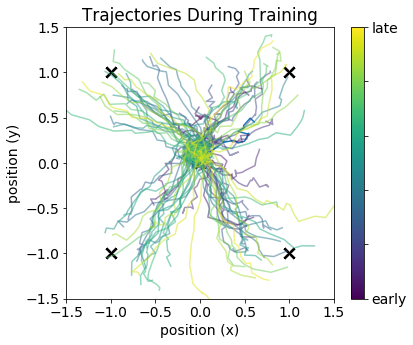

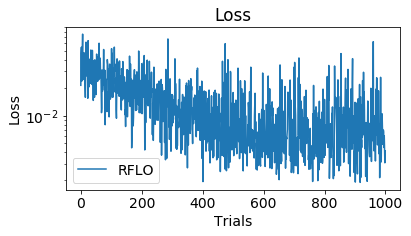

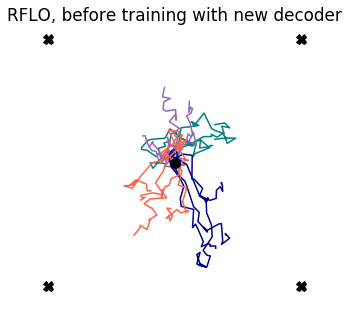

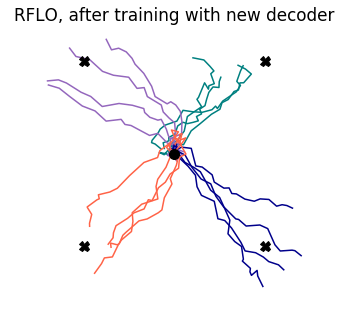

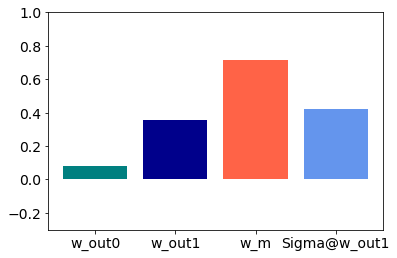

M norm: 1.17	 M angle: 0.50, 57 iterations
w_out1 norm: 1.52	 w_out vs. w_out1 angle: 0.49
w_m norm: 1.17	 w_out1 vs. w_m angle: 0.50
M norm: 0.00	 M angle: 1.00, 0 iterations
 w_m vs. w_m_sigma angle: 1.00
 w_out1 vs. w_m_sigma angle: 0.50

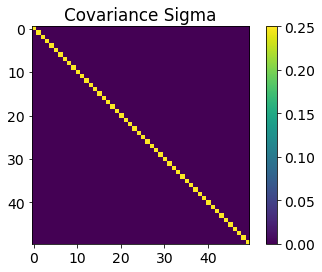

500it [00:04, 104.74it/s]
1000it [00:11, 83.66it/s]
500it [00:04, 100.90it/s]


AR early fit 0.936, late fit 0.960


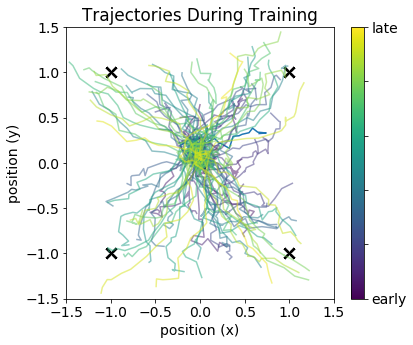

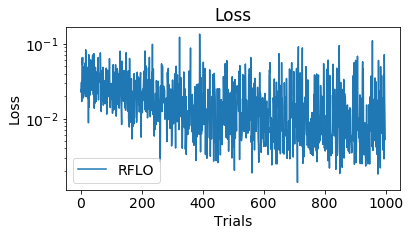

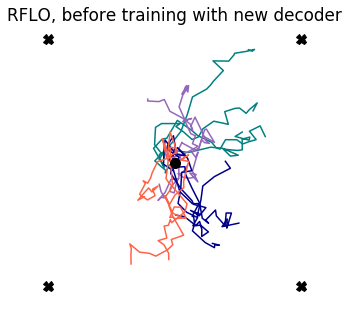

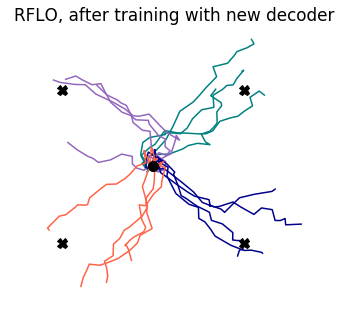

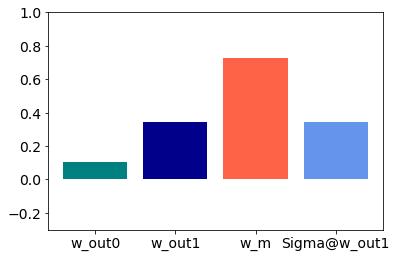

In [6]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.2,eta_out=0.1,
               sig_in=0.0,sig_rec=0.25,sig_out=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               rng=np.random.RandomState(72))
params.print_params()

# Initialize RNN
net0 = RNN(params)
sim0 = Simulation(net0)
rflo = RFLO(net0,apply_to=['w_rec'],online=False)
sim0.run_session(n_trials=2500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=20)

fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='Pretrain RFLO, train '+r'$W_{rec}$')






""" Average over multiple seeds """
# seeds = [0,22,33,47] #,54,72,81]
# overlaps = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
# n_changes = [75,75,60,50,50,50,30,30,1]
seeds=[22,55,1918]
# overlaps = [0.4,0.5,0.8]
# n_changes = [70,50,30]

overlap = 1
n_change = 0
dimensions = [5,10,25,50]

overlap_w_out0 = 0.5
n_change_w_out0 = 50
overlap_w_m = 0.5 # overlap with w_out1
n_change_w_m = 50
train_duration=1000

vary_sigma_w_m = True

stats = {}
stats['corr1'] = []
stats['corr2'] = []
stats['corr3'] = []
stats['corr4'] = []
stats['corrcoef'] = []


stats['seeds'] = seeds
stats['overlap'] = overlap
stats['overlap_w_out0'] = overlap_w_out0
stats['n_change_w_out0'] = n_change_w_out0
stats['overlap_w_m'] = overlap_w_m
stats['n_change_w_m'] = n_change_w_m
stats['dimensions'] = dimensions

for seed in seeds:

    corr1_list = []
    corr2_list = []
    corr3_list = []
    corr4_list = []
    corrcoef_list = []


    #for overlap,n_change in zip(overlaps,n_changes):
    for dim in dimensions:
        
        """ let overlap between w_out0 and w_out1 be constant """
        w_out1 = choose_aligned_matrix(net0.w_out.copy(),n_change=n_change_w_out0,overlap=overlap_w_out0,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
        """ change overlap between w_out1 and w_m  """
        w_m = choose_aligned_matrix(w_out1,n_change=n_change_w_m,overlap=overlap_w_m,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)

        # confirm overlap between w_out1 and w_out
        norm, angle = return_norm_and_angle(net0.w_out,w_out1)
        print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out1 and w_m
        norm, angle = return_norm_and_angle(w_out1,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out1 vs. w_m angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out and w_m
        norm, angle = return_norm_and_angle(net0.w_out,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out vs. w_m angle: {:.2f}'.format(angle),end='')
        
        
        """ Version 1 - use w_m, find sigma that is partially aligned, and generate covariance matrix """
        if vary_sigma_w_m:
            w_m_sigma = choose_aligned_matrix(w_m,n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
        
        #""" Version 2 - Use w_out1, find sigma that is partially aligned, and generate covariance matrix """
        #w_m_sigma = choose_aligned_matrix(w_out1,n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
        
        
        _, angle = return_norm_and_angle(w_m,w_m_sigma)
        print('\n w_m vs. w_m_sigma angle: {:.2f}'.format(angle),end='')
        _, angle = return_norm_and_angle(w_out1,w_m_sigma)
        print('\n w_out1 vs. w_m_sigma angle: {:.2f}'.format(angle),end='')
        
        
        """ Choose Noise Covariance """
        Q,R = LA.qr(w_m_sigma.T)
        u0 = Q[:,0]
        u1 = Q[:,1]
        Sigma = np.outer(u0,u0) + np.outer(u1,u1)

        for d in range(2,dim):
            u = Q[:,d]
            Sigma += np.outer(u,u)
            
        #Sigma /= dim # Do I need to do this? NO
        """multiply by sig_rec (since I don't do this in code)"""
        Sigma *= net0.sig_rec
        
        fig,ax = plt.subplots(1,1)
        plt.imshow(Sigma)
        plt.title('Covariance Sigma')
        plt.colorbar()
        plt.show()
                
        
        net1_pre = RNN(params,sig_rec_covariance=Sigma)
        net1_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net1_pre.set_weights(w_out = w_out1)
        net1_pre.set_weights(w_m = w_m.T)

        # unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
        net1 = RNN(params,sig_rec_covariance=Sigma)
        net1.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net1.set_weights(w_out = w_out1)
        net1.set_weights(w_m = w_m.T)




        """ Track activity with new decoder, before training """

        sim1_pre = Simulation(net1_pre)
        trackvars = TrackVars(net1_pre,apply_to=[]) 
        sim1_pre.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
        #fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        """ Train with new decoder """

        sim1_train = Simulation(net1)
        rflo = RFLO(net1,apply_to=['w_rec'],online=False)
        sim1_train.run_session(n_trials=train_duration, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','loss','err'], plot=True, plot_freq=10)

        """ Track activity with new decoder, after training """
        net1_post = RNN(params,sig_rec_covariance=Sigma)
        net1_post.set_weights(w_in=net1.w_in.copy(), w_rec=net1.w_rec.copy())
        net1_post.set_weights(w_out = net1.w_out)
        net1_post.set_weights(w_m = net1.w_m)

        sim1_post = Simulation(net1_post)
        trackvars = TrackVars(net1_post,apply_to=[]) 
        sim1_post.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)

        
        fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        fig = plot_trained_trajectories(sim=sim1_post, tasks=[task1,task2,task3,task4],title='RFLO, after training with new decoder')
        
        
        """ Calculate F fields """
        F_early, score_early = flow_field_data(sim1_pre.session_probes['h'])
        F_late, score_late = flow_field_data(sim1_post.session_probes['h'])

        print('AR early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

        Fdata = F_late - F_early

        # separate train and test data from sim1_train
        n_total = len(sim1_train.session_probes['h'])
        n_train = int(0.5 * n_total)
        idx_train = np.random.RandomState(1975+seed).choice(np.arange(0,n_total),size=n_train,replace=False).astype(int)
        idx_test = np.arange(0,n_total)[~idx_train].astype(int)
        #idx_test=idx_train

        h_train = np.asarray(sim1_train.session_probes['h'])[idx_train,:,:,:]
        err_train = np.asarray(sim1_train.session_probes['err'])[idx_train,:,:,:]

        Fpred_w_out = flow_field_predicted(net0.w_out,err_train,h_train)
        Fpred_w_out1 = flow_field_predicted(w_out1,err_train,h_train)
        Fpred_w_m = flow_field_predicted(w_m,err_train,h_train)
        Fpred_cov_w_out1 = flow_field_predicted(w_out1@Sigma.T,err_train,h_train) # nonisotropic noise, wout1 is tranposed inside function

        h_test = np.asarray(sim1_train.session_probes['h'])[idx_test,:,:,:]

        corr1 = calculate_flow_field_correlation(Fpred_w_out,Fdata,h_test) # could also sample sim_test
        corr1_list.append(corr1)

        corr2 = calculate_flow_field_correlation(Fpred_w_out1,Fdata,h_test) # could also sample sim_test
        corr2_list.append(corr2)

        corr3 = calculate_flow_field_correlation(Fpred_w_m,Fdata,h_test) # could also sample sim_test
        corr3_list.append(corr3)
        
        corr4 = calculate_flow_field_correlation(Fpred_cov_w_out1,Fdata,h_test) # could also sample sim_test
        corr4_list.append(corr4)
        
        fig,ax = plt.subplots(1,1)
        plt.bar([0,1,2,3],[corr1,corr2,corr3,corr4],tick_label=['w_out0','w_out1','w_m','Sigma@w_out1'],color=['teal','darkblue','tomato','cornflowerblue'])
        plt.ylim([-0.3,1])
        plt.show()
        

        
    # update
    stats['corr1'].append(corr1_list)
    stats['corr2'].append(corr2_list)
    stats['corr3'].append(corr3_list)
    stats['corr4'].append(corr4_list)
    #stats['corrcoef'].append(corrcoef_list)



In [ ]:
""" save dict with unique name """
stats_rflo_noniso_fullrank = stats

save = True
tag = '-05-19-v2-w_m05'

if save:
    
    with open(folder+'stats_rflo_noniso_fullrank'+tag+'.pickle', 'wb') as handle:
        pickle.dump(stats_rflo_noniso_fullrank, handle, protocol=pickle.HIGHEST_PROTOCOL)


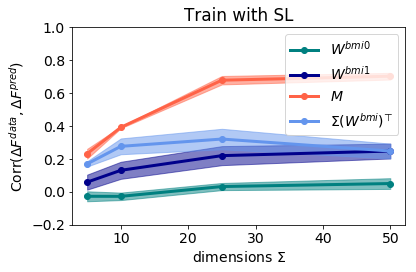

In [7]:
""" Same plot using flow field """
paper = False
save = False


fig,ax = plt.subplots(1,1,figsize=(6,4))

n_samples = len(stats['corr1'])
mn1 = np.mean(np.asarray(stats['corr1']),axis=0)
std1 = np.std(np.asarray(stats['corr1']),axis=0)
sem1 = std1/np.sqrt(n_samples)

mn2 = np.mean(np.asarray(stats['corr2']),axis=0)
std2 = np.std(np.asarray(stats['corr2']),axis=0)
sem2 = std2/np.sqrt(n_samples)

mn3 = np.mean(np.asarray(stats['corr3']),axis=0)
std3 = np.std(np.asarray(stats['corr3']),axis=0)
sem3 = std3/np.sqrt(n_samples)

mn4 = np.mean(np.asarray(stats['corr4']),axis=0)
std4 = np.std(np.asarray(stats['corr4']),axis=0)
sem4 = std4/np.sqrt(n_samples)

plt.plot(dimensions,mn1,'o-',linewidth=3,label=r'$W^{bmi0}$',color='teal')
plt.fill_between(dimensions,mn1-sem1,mn1+sem1,alpha=0.5,color='teal')


plt.plot(dimensions,mn2,'o-',linewidth=3,label=r'$W^{bmi1}$',color='darkblue')
plt.fill_between(dimensions,mn2-sem2,mn2+sem2,alpha=0.5,color='darkblue')

plt.plot(dimensions,mn3,'o-',linewidth=3,label=r'$ M$',color='tomato')
plt.fill_between(dimensions,mn3-sem3,mn3+sem3,alpha=0.5,color='tomato')

plt.plot(dimensions,mn4,'o-',linewidth=3,label=r'$\Sigma (W^{bmi})^\top$',color='cornflowerblue')
plt.fill_between(dimensions,mn4-sem4,mn4+sem4,alpha=0.5,color='cornflowerblue')

plt.ylim([-0.2,1])
plt.legend()
plt.title('Train with SL')
plt.xlabel('dimensions '+r'$\Sigma$')
plt.ylabel('Corr'+r'$(\Delta F^{data}, \Delta F^{pred})$')

plt.tight_layout()

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=[5,10,25,50],ylabels=[0,0.25,0.5,0.75,1],ticksize=10,linewidth=2,ylim=[-.2,1],figsize=(2.25,3),labelsize=10)

plt.show()

if save:
    if paper:
        fig.savefig(folder+'rflo-dF-noniso-fullrank.pdf')
    else:
        fig.savefig(folder+'rflo-dF-noniso-fullrank.pdf')


# Part 4 - REINFORCE with Sigma of increasing dimensions

6it [00:00, 57.96it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.25
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.2
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7ff8b0219798>


2500it [00:29, 83.51it/s]



~~~~ OVERLAP 0.6, SEED 55


M norm: 1.05	 M angle: 0.60, 3 iterations
w_out1 norm: 1.50	 w_out vs. w_out1 angle: 0.51
w_m norm: 1.05	 w_out1 vs. w_m angle: 0.60
M norm: 1.05	 M angle: 0.60, 3 iterations
 w_m vs. w_m_sigma angle: 1.00
 w_out1 vs. w_m_sigma angle: 0.60

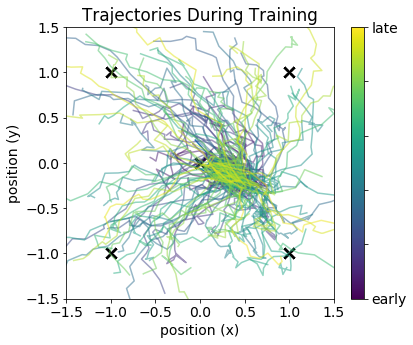

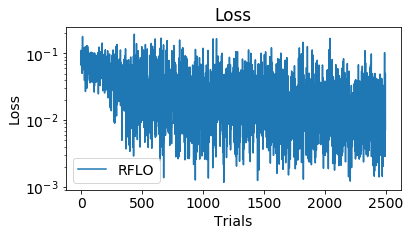

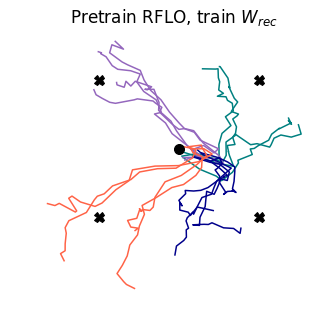

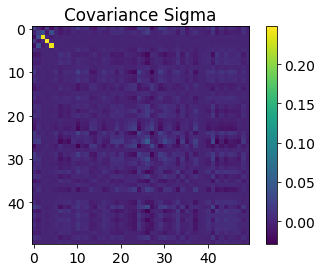

500it [00:05, 99.03it/s] 
5000it [01:06, 75.47it/s]
500it [00:05, 87.05it/s]


AR early fit 0.989, late fit 0.992


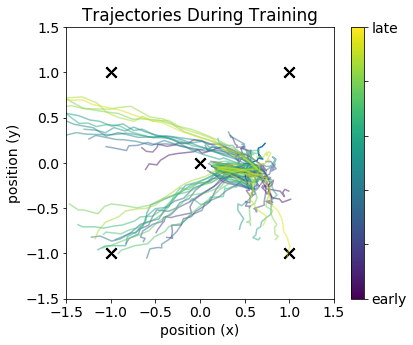

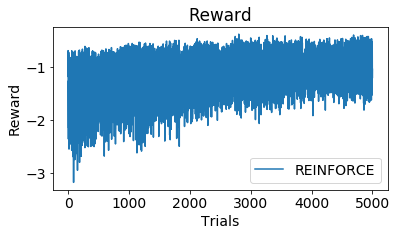

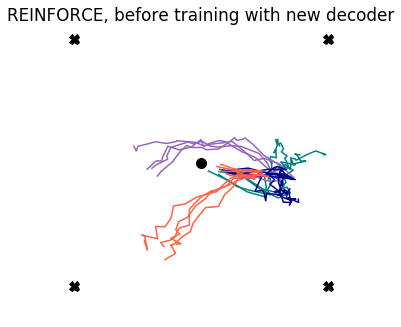

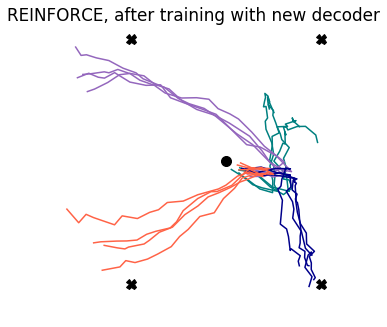

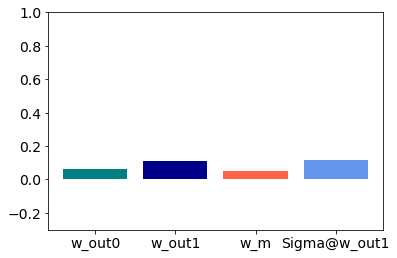


~~~~ OVERLAP 0.6, SEED 55


M norm: 1.05	 M angle: 0.60, 3 iterations
w_out1 norm: 1.50	 w_out vs. w_out1 angle: 0.51
w_m norm: 1.05	 w_out1 vs. w_m angle: 0.60
M norm: 1.05	 M angle: 0.60, 3 iterations
 w_m vs. w_m_sigma angle: 1.00
 w_out1 vs. w_m_sigma angle: 0.60

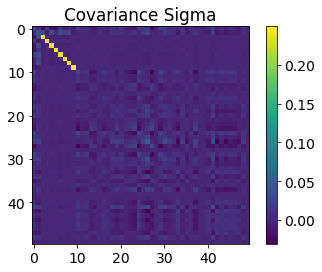

500it [00:04, 90.94it/s]
5000it [01:02, 79.82it/s]
500it [00:05, 99.41it/s]


AR early fit 0.976, late fit 0.986


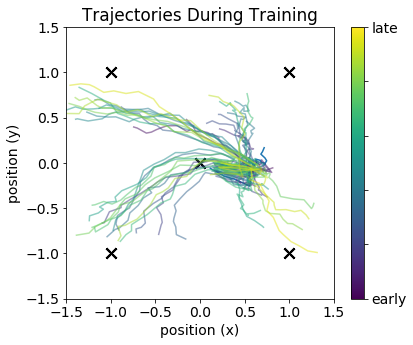

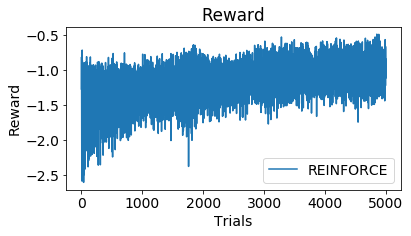

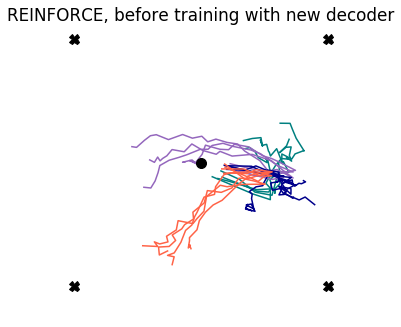

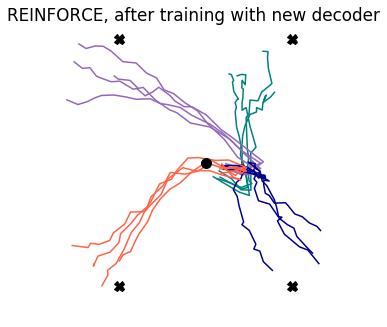

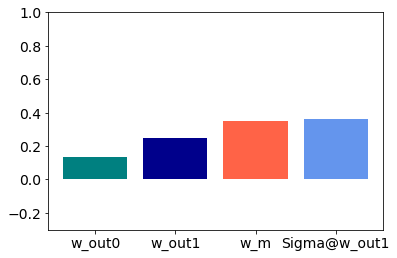


~~~~ OVERLAP 0.6, SEED 55


M norm: 1.05	 M angle: 0.60, 3 iterations
w_out1 norm: 1.50	 w_out vs. w_out1 angle: 0.51
w_m norm: 1.05	 w_out1 vs. w_m angle: 0.60
M norm: 1.05	 M angle: 0.60, 3 iterations
 w_m vs. w_m_sigma angle: 1.00
 w_out1 vs. w_m_sigma angle: 0.60

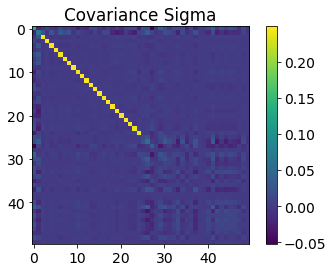

500it [00:06, 83.29it/s]
5000it [01:05, 76.62it/s]
500it [00:05, 96.10it/s]


AR early fit 0.955, late fit 0.975


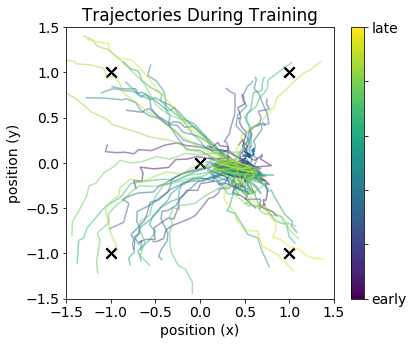

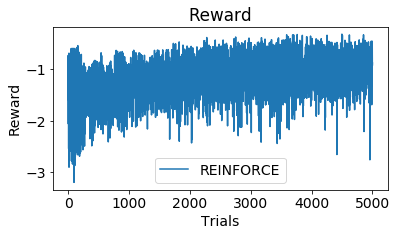

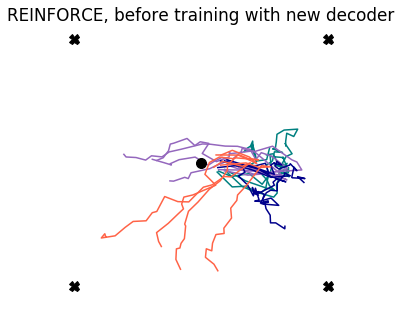

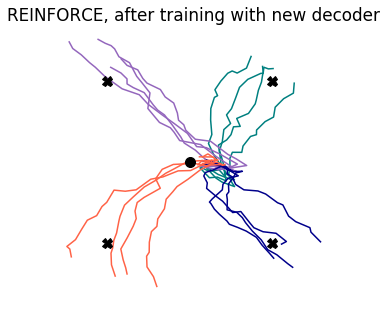

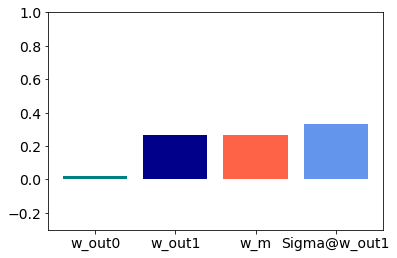


~~~~ OVERLAP 0.6, SEED 55


M norm: 1.05	 M angle: 0.60, 3 iterations
w_out1 norm: 1.50	 w_out vs. w_out1 angle: 0.51
w_m norm: 1.05	 w_out1 vs. w_m angle: 0.60
M norm: 1.05	 M angle: 0.60, 3 iterations
 w_m vs. w_m_sigma angle: 1.00
 w_out1 vs. w_m_sigma angle: 0.60

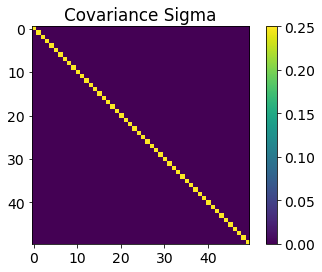

500it [00:05, 89.10it/s] 
5000it [01:01, 80.88it/s]
500it [00:04, 101.23it/s]


AR early fit 0.936, late fit 0.964


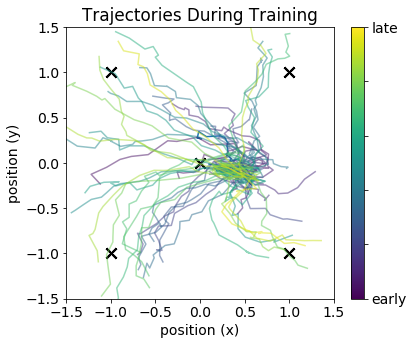

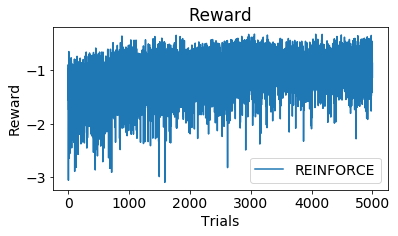

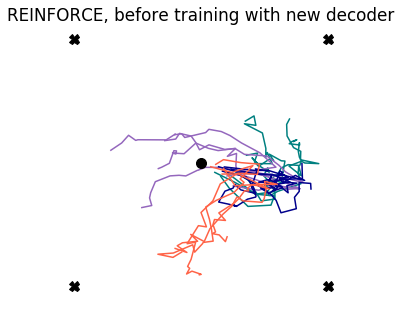

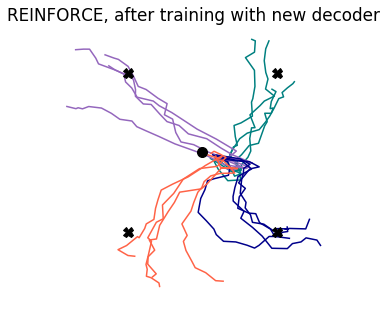

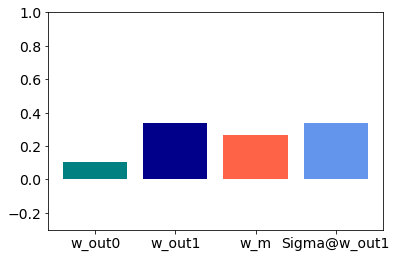


~~~~ OVERLAP 0.6, SEED 72


M norm: 1.09	 M angle: 0.61, 12 iterations
w_out1 norm: 1.52	 w_out vs. w_out1 angle: 0.50
w_m norm: 1.09	 w_out1 vs. w_m angle: 0.61
M norm: 1.09	 M angle: 0.61, 12 iterations
 w_m vs. w_m_sigma angle: 1.00
 w_out1 vs. w_m_sigma angle: 0.61

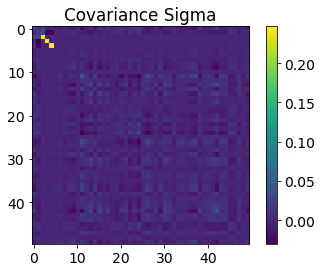

500it [00:05, 94.74it/s]
5000it [01:05, 76.69it/s]
500it [00:05, 83.50it/s]


AR early fit 0.988, late fit 0.994


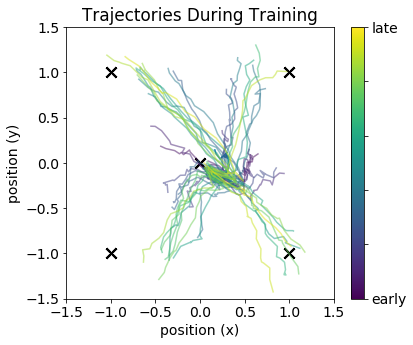

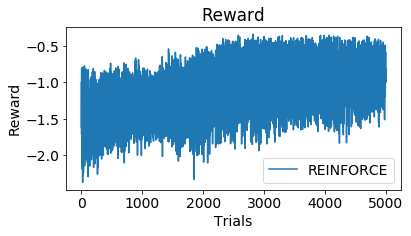

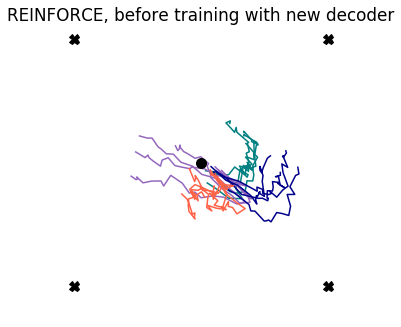

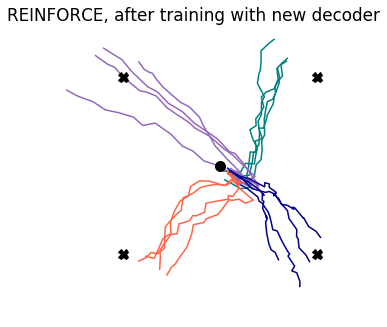

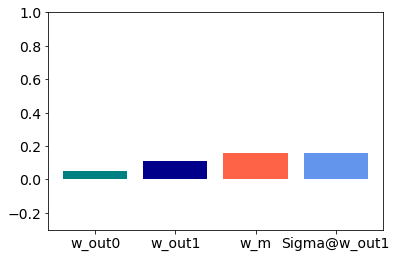


~~~~ OVERLAP 0.6, SEED 72


M norm: 1.09	 M angle: 0.61, 12 iterations
w_out1 norm: 1.52	 w_out vs. w_out1 angle: 0.50
w_m norm: 1.09	 w_out1 vs. w_m angle: 0.61
M norm: 1.09	 M angle: 0.61, 12 iterations
 w_m vs. w_m_sigma angle: 1.00
 w_out1 vs. w_m_sigma angle: 0.61

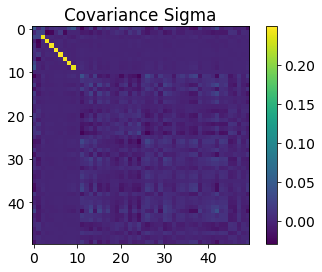

500it [00:05, 87.90it/s] 
5000it [01:00, 82.42it/s]
500it [00:04, 106.09it/s]


AR early fit 0.976, late fit 0.989


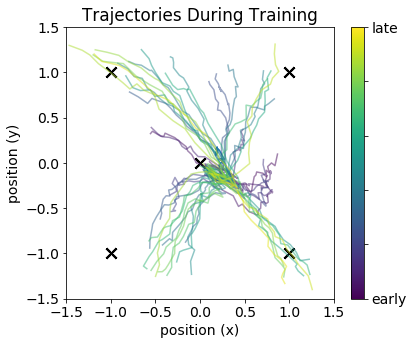

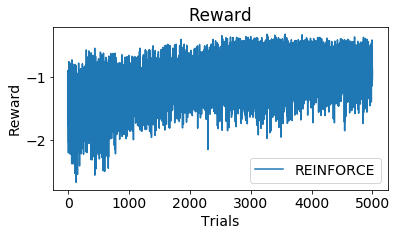

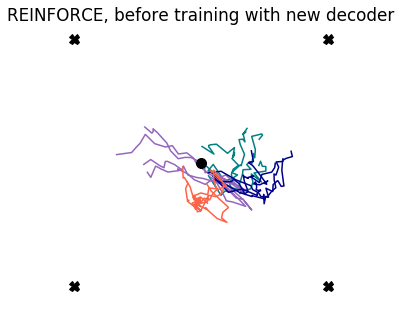

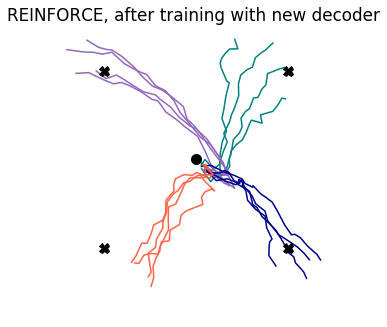

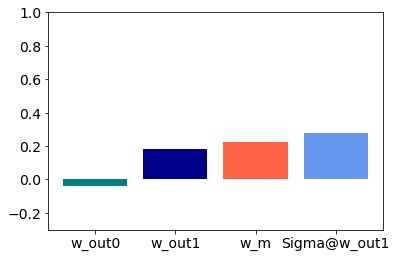


~~~~ OVERLAP 0.6, SEED 72


M norm: 1.09	 M angle: 0.61, 12 iterations
w_out1 norm: 1.52	 w_out vs. w_out1 angle: 0.50
w_m norm: 1.09	 w_out1 vs. w_m angle: 0.61
M norm: 1.09	 M angle: 0.61, 12 iterations
 w_m vs. w_m_sigma angle: 1.00
 w_out1 vs. w_m_sigma angle: 0.61

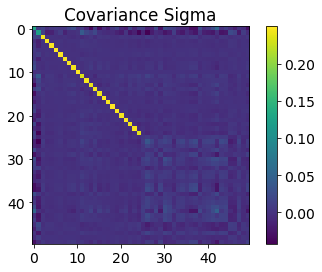

500it [00:05, 97.31it/s]
5000it [01:00, 83.04it/s]
500it [00:05, 98.18it/s]


AR early fit 0.955, late fit 0.978


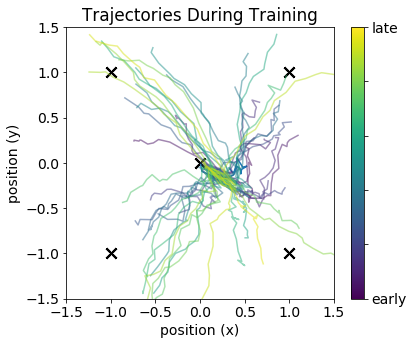

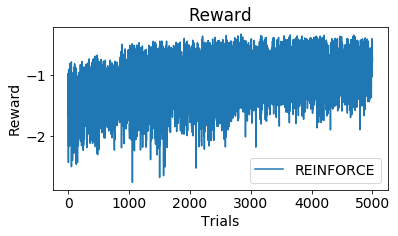

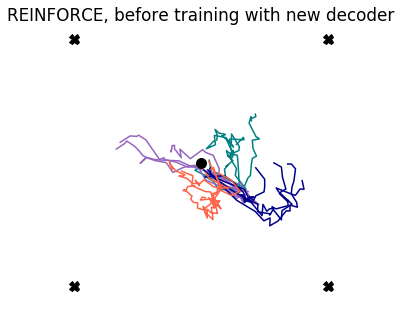

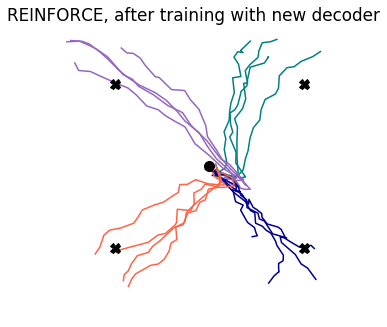

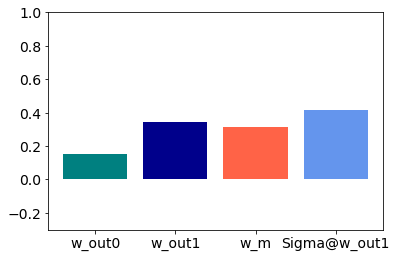


~~~~ OVERLAP 0.6, SEED 72


M norm: 1.09	 M angle: 0.61, 12 iterations
w_out1 norm: 1.52	 w_out vs. w_out1 angle: 0.50
w_m norm: 1.09	 w_out1 vs. w_m angle: 0.61
M norm: 1.09	 M angle: 0.61, 12 iterations
 w_m vs. w_m_sigma angle: 1.00
 w_out1 vs. w_m_sigma angle: 0.61

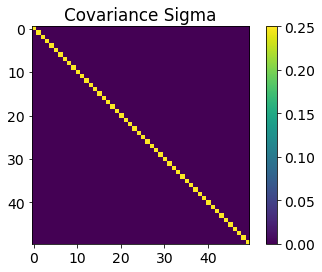

500it [00:04, 104.17it/s]
5000it [00:59, 81.15it/s]
500it [00:05, 95.97it/s] 


AR early fit 0.936, late fit 0.968


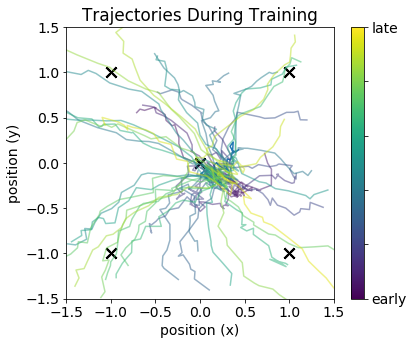

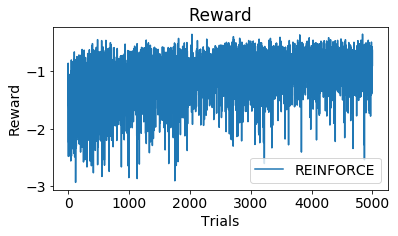

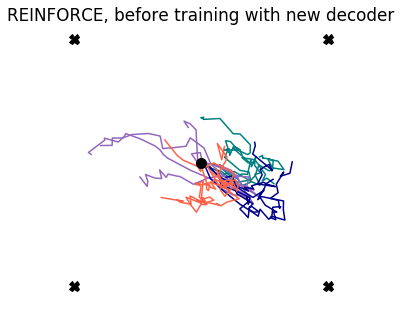

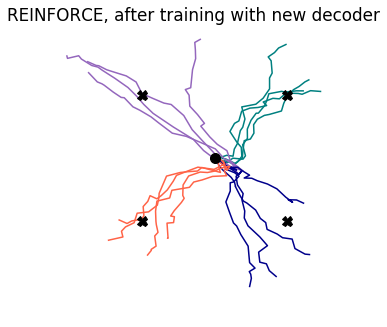

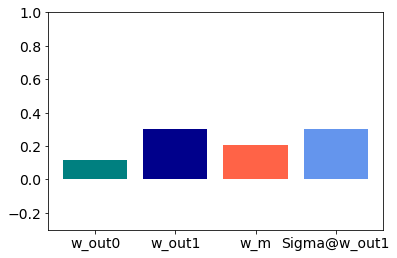

In [17]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.2,eta_out=0.1,
               sig_in=0.0,sig_rec=0.25,sig_out=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               rng=np.random.RandomState(72))
params.print_params()

""" Average over multiple seeds """

# seeds = [0,22,33,47] #,54,72,81]
# overlaps = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
# n_changes = [75,75,60,50,50,50,30,30,1]
#overlaps = [0.4,0.5,0.6,0.7,0.8,0.9]
#n_changes = [60,50,50,40,30,5]
seeds=[55,72]

""" vary overlap between w_out and w_m_sigma that generates covariance matrix """
# overlaps = [0.4,0.6,0.8]
# n_changes = [60,50,30]

overlap = 0.6
n_change = 50

overlap_w_out0 = 0.5
n_change_w_out0 = 50
pretrain_duration = 2500
train_duration=5000

overlap_w_m = 0.6 # We want W_m to be the same as wbmi1 here, so learning can occur with REINFORCE
n_change_w_m = 50

vary_sigma_wout1 = True

dimensions = [5,10,25,50]


# Initialize RNN, train with RFLO
net0 = RNN(params)
sim0 = Simulation(net0)
rflo = RFLO(net0,apply_to=['w_rec'],online=False)
sim0.run_session(n_trials=pretrain_duration, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=20)

fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='Pretrain RFLO, train '+r'$W_{rec}$')









stats = {}
stats['corr1'] = []
stats['corr2'] = []
stats['corr3'] = []
stats['corr4'] = []
stats['corrcoef'] = []


stats['seeds'] = seeds
stats['overlap'] = overlap
stats['overlap_w_m'] = overlap_w_m


for seed in seeds:

    corr1_list = []
    corr2_list = []
    corr3_list = []
    corr4_list = []
    corrcoef_list = []
    

    #for overlap,n_change in zip(overlaps,n_changes):
    for dim in dimensions:
        
        print('\n~~~~ OVERLAP {}, SEED {}'.format(overlap,seed))
        print('\n')
        
        """ choose new decoder w_out1, change overlap """
        w_out1 = choose_aligned_matrix(net0.w_out.copy(),n_change=n_change_w_out0,overlap=overlap_w_out0,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
        """ choose new internal model w_m, keep constant """
        w_m = choose_aligned_matrix(w_out1.copy(),n_change=n_change_w_m,overlap=overlap_w_m,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)

        
        # confirm overlap between w_out1 and w_out
        norm, angle = return_norm_and_angle(net0.w_out,w_out1)
        print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out1 and w_m
        norm, angle = return_norm_and_angle(w_out1,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out1 vs. w_m angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out and w_m
        norm, angle = return_norm_and_angle(net0.w_out,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out vs. w_m angle: {:.2f}'.format(angle),end='')
        
        
        
        """ Version 1 - use w_m, find sigma that is partially aligned, and generate covariance matrix """
        #w_m_sigma = choose_aligned_matrix(w_m,n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
        
        """ Version 2 - Use w_out1, find sigma that is partially aligned, and generate covariance matrix """
        if vary_sigma_wout1:
            w_m_sigma = choose_aligned_matrix(w_out1,n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
        
        
        _, angle = return_norm_and_angle(w_m,w_m_sigma)
        print('\n w_m vs. w_m_sigma angle: {:.2f}'.format(angle),end='')
        _, angle = return_norm_and_angle(w_out1,w_m_sigma)
        print('\n w_out1 vs. w_m_sigma angle: {:.2f}'.format(angle),end='')
        
        
        """ Choose Noise Covariance """
        Q,R = LA.qr(w_m_sigma.T)
        u0 = Q[:,0]
        u1 = Q[:,1]
        Sigma = np.outer(u0,u0) + np.outer(u1,u1)

        for d in range(2,dim):
            u = Q[:,d]
            Sigma += np.outer(u,u)
            
        #Sigma /= dim # Do I need to do this? NO
        """multiply by sig_rec (since I don't do this in code)"""
        Sigma *= net0.sig_rec
        
        fig,ax = plt.subplots(1,1)
        plt.imshow(Sigma)
        plt.title('Covariance Sigma')
        plt.colorbar()
        plt.show()
        
        
        net2_pre = RNN(params,sig_rec_covariance=Sigma)
        net2_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net2_pre.set_weights(w_out = w_out1)
        net2_pre.set_weights(w_m = 0*w_m.T) # shouldn't matter for REINFORCE

        # unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
        net2 = RNN(params,sig_rec_covariance=Sigma)
        net2.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net2.set_weights(w_out = w_out1)
        net2.set_weights(w_m = 0*w_m.T) # shouldn't matter for REINFORCE



        """ Track activity with new decoder, before training """

        sim2_pre = Simulation(net2_pre)
        trackvars = TrackVars(net2_pre,apply_to=[]) 
        sim2_pre.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
        #fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        """ Train with new decoder """

        sim2_train = Simulation(net2)
        reinforce = REINFORCE(net2,apply_to=['w_rec'],online=False,tau_reward=5)
        sim2_train.run_session(n_trials=train_duration, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['h','reward','err'], plot=True, plot_freq=100)

        """ Track activity with new decoder, after training """
        net2_post = RNN(params,sig_rec_covariance=Sigma)
        net2_post.set_weights(w_in=net2.w_in.copy(), w_rec=net2.w_rec.copy())
        net2_post.set_weights(w_out = net2.w_out)
        net2_post.set_weights(w_m = 0*net2.w_m) # shouldn't matter for REINFORCE

        sim2_post = Simulation(net2_post)
        trackvars = TrackVars(net2_post,apply_to=[]) 
        sim2_post.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)

        
        fig = plot_trained_trajectories(sim=sim2_pre, tasks=[task1,task2,task3,task4],title='REINFORCE, before training with new decoder')

        fig = plot_trained_trajectories(sim=sim2_post, tasks=[task1,task2,task3,task4],title='REINFORCE, after training with new decoder')
        
        
        """ Calculate F fields """
        F_early, score_early = flow_field_data(sim2_pre.session_probes['h'])
        F_late, score_late = flow_field_data(sim2_post.session_probes['h'])

        print('AR early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

        Fdata = F_late - F_early

        # separate train and test data from sim1_train
        n_total = len(sim2_train.session_probes['h'])
        n_train = int(0.5 * n_total)
        idx_train = np.random.RandomState(1975+seed).choice(np.arange(0,n_total),size=n_train,replace=False).astype(int)
        idx_test = np.arange(0,n_total)[~idx_train].astype(int)
        #idx_test=idx_train

        h_train = np.asarray(sim2_train.session_probes['h'])[idx_train,:,:,:]
        err_train = np.asarray(sim2_train.session_probes['err'])[idx_train,:,:,:]

        Fpred_w_out = flow_field_predicted(net0.w_out,err_train,h_train)
        Fpred_w_out1 = flow_field_predicted(w_out1,err_train,h_train)
        Fpred_w_m = flow_field_predicted(w_m,err_train,h_train)
        Fpred_cov_w_out1 = flow_field_predicted(w_out1@Sigma.T,err_train,h_train) # nonisotropic noise, wout1 is tranposed inside function

        h_test = np.asarray(sim2_train.session_probes['h'])[idx_test,:,:,:]

        corr1 = calculate_flow_field_correlation(Fpred_w_out,Fdata,h_test) # could also sample sim_test
        corr1_list.append(corr1)

        corr2 = calculate_flow_field_correlation(Fpred_w_out1,Fdata,h_test) # could also sample sim_test
        corr2_list.append(corr2)

        corr3 = calculate_flow_field_correlation(Fpred_w_m,Fdata,h_test) # could also sample sim_test
        corr3_list.append(corr3)
        
        corr4 = calculate_flow_field_correlation(Fpred_cov_w_out1,Fdata,h_test) # could also sample sim_test
        corr4_list.append(corr4)
        
        fig,ax = plt.subplots(1,1)
        plt.bar([0,1,2,3],[corr1,corr2,corr3,corr4],tick_label=['w_out0','w_out1','w_m','Sigma@w_out1'],color=['teal','darkblue','tomato','cornflowerblue'])
        plt.ylim([-0.3,1])
        plt.show()
        
        
        
        
        
        
    # update
    stats['corr1'].append(corr1_list)
    stats['corr2'].append(corr2_list)
    stats['corr3'].append(corr3_list)
    stats['corr4'].append(corr4_list)
    #stats['corrcoef'].append(corrcoef_list)
    


### Save statistics

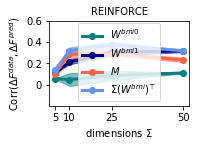

In [21]:
""" Same plot using flow field """
paper = True
save = True

tag = '-5-18-v1'


fig,ax = plt.subplots(1,1,figsize=(6,4))

n_samples = len(stats['corr1'])
mn1 = np.mean(np.asarray(stats['corr1']),axis=0)
std1 = np.std(np.asarray(stats['corr1']),axis=0)
sem1 = std1/np.sqrt(n_samples)

mn2 = np.mean(np.asarray(stats['corr2']),axis=0)
std2 = np.std(np.asarray(stats['corr2']),axis=0)
sem2 = std2/np.sqrt(n_samples)

mn3 = np.mean(np.asarray(stats['corr3']),axis=0)
std3 = np.std(np.asarray(stats['corr3']),axis=0)
sem3 = std3/np.sqrt(n_samples)

mn4 = np.mean(np.asarray(stats['corr4']),axis=0)
std4 = np.std(np.asarray(stats['corr4']),axis=0)
sem4 = std4/np.sqrt(n_samples)

plt.plot(dimensions,mn1,'o-',linewidth=3,label=r'$W^{bmi0}$',color='teal')
plt.fill_between(dimensions,mn1-sem1,mn1+sem1,alpha=0.5,color='teal')


plt.plot(dimensions,mn2,'o-',linewidth=3,label=r'$W^{bmi1}$',color='darkblue')
plt.fill_between(dimensions,mn2-sem2,mn2+sem2,alpha=0.5,color='darkblue')

plt.plot(dimensions,mn3,'o-',linewidth=3,label=r'$ M$',color='tomato')
plt.fill_between(dimensions,mn3-sem3,mn3+sem3,alpha=0.5,color='tomato')

plt.plot(dimensions,mn4,'o-',linewidth=3,label=r'$\Sigma (W^{bmi})^\top$',color='cornflowerblue')
plt.fill_between(dimensions,mn4-sem4,mn4+sem4,alpha=0.5,color='cornflowerblue')

#plt.axhline(y=overlap_w_m,linestyle='--',label='overlap w_m w_out1')
plt.ylim([-0.2,1])
plt.legend()
plt.title('REINFORCE')
#plt.xlabel('alignment '+r'$M \angle W^{bmi1}$')
plt.xlabel('dimensions '+r'$\Sigma$')
plt.ylabel('Corr'+r'$(\Delta F^{data}, \Delta F^{pred})$')

plt.tight_layout()

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=dimensions,ylabels=[0,0.2,0.4,0.6],ticksize=10,linewidth=2,ylim=[-.2,0.6],figsize=(2.25,3),labelsize=10)

plt.show()

if save:
    if paper:
        fig.savefig(folder+'reinforce-dF-noniso-fullrank'+tag+'.pdf')
    else:
        fig.savefig(folder+'reinforce-dF-noniso-fullrank'+tag+'.pdf')
        
        #RUN AGAIN WITH 0.5
